## Imports

In [51]:
import io
import pathlib
import pickle
import re
import pandas as pd
pd.set_option('display.max_rows', None)

import ads
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

from astropy.stats import median_absolute_deviation as MAD
from gala.units import galactic

from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm

from astropy.table import Table, vstack, hstack, join, unique

from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select Data Release 3

import time

%matplotlib inline
%config InlineBackend.figure_format='retina'


In [52]:
galcen_frame = coord.Galactocentric(
    galcen_distance=8.275 * u.kpc, galcen_v_sun=[8.4, 251, 8.4] * u.km / u.s
)
mw = gp.MilkyWayPotential2022()

In [3]:
mwstreams = galstreams.MWStreams(implement_Off=True)

Initializing galstreams library from master_log... 


In [4]:
mwstreams

{'20.0-1-M18': <galstreams.core.Track6D at 0x7fdb40161400>,
 '300S-F18': <galstreams.core.Track6D at 0x7fdae5b995e0>,
 'AAU-ATLAS-L21': <galstreams.core.Track6D at 0x7fdae5ab6d90>,
 'AAU-AliqaUma-L21': <galstreams.core.Track6D at 0x7fdb41a13c40>,
 'ACS-R21': <galstreams.core.Track6D at 0x7fdae5bf1f70>,
 'ATLAS-I21': <galstreams.core.Track6D at 0x7fdae5aa0580>,
 'ATLAS-I24': <galstreams.core.Track6D at 0x7fdae5b99850>,
 'Acheron-G09': <galstreams.core.Track6D at 0x7fdae5ab1a60>,
 'Alpheus-G13': <galstreams.core.Track6D at 0x7fdae5ab69d0>,
 'Aquarius-W11': <galstreams.core.Track6D at 0x7fdae59ffdc0>,
 'C-10-I24': <galstreams.core.Track6D at 0x7fdae37d8e20>,
 'C-11-I24': <galstreams.core.Track6D at 0x7fdae355a370>,
 'C-12-I24': <galstreams.core.Track6D at 0x7fdae33fcfa0>,
 'C-13-I24': <galstreams.core.Track6D at 0x7fdae3645d90>,
 'C-19-I21': <galstreams.core.Track6D at 0x7fdae365ec70>,
 'C-19-I24': <galstreams.core.Track6D at 0x7fdae3240760>,
 'C-20-I24': <galstreams.core.Track6D at 0x7fd

In [5]:
names = ['20.0-1', '300S', 'ATLAS-Aliqa Uma', 'Acheron',
       'Alpheus', 'Aquarius', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19',
       'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-4', 'C-5', 'C-7', 'C-8',
       'C-9', 'Cetus-Palca', 'Cocytos', 'Corvus',
       'Elqui', 'Eridanus', 'GD-1', 'Gaia-1', 
       'Gaia-11', 'Gaia-12', 'Gaia-2', 'Gaia-3', 'Gaia-4', 'Gaia-5',
       'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Gunnthra', 'Hermus',
       'Hrid', 'Hydrus', 'Hyllus', 'Indus', 'Jet', 'Jhelum',
       'Kshir', 'Kwando', 'Wukong', 'Leiptr', 'Lethe', 'M2',
       'M3', 'M30', 'M5', 'M68', 'M92', 'Molonglo',
       'Murrumbidgee', 'NGC 1261',
       'NGC 1851', 'NGC 2298', 'NGC 2808', 'NGC 288', 'NGC 3201',
       'NGC 5053', 'NGC 5466', 'NGC 5824', 'NGC 6101', 'NGC 6362',
       'NGC 6397', 'NGC 7492', 'New-1', 'New-10', 'New-11', 'New-12',
       'New-13', 'New-14', 'New-15', 'New-16', 'New-17', 'New-18',
       'New-19', 'New-2', 'New-20', 'New-21', 'New-22', 'New-23',
       'New-24', 'New-25', 'New-26', 'New-27', 'New-3', 'New-4', 'New-5',
       'New-6', 'New-7', 'New-8', 'New-9', 'Omega Centauri',
       'Ophiuchus', 'Orinoco', 'Orphan-Chenab', 'PS1-A', 'PS1-B', 'PS1-C',
       'PS1-D', 'PS1-E', 'Palomar 13', 'Palomar 15', 'Palomar 5',  'Parallel',
       'Pegasus', 'Perpendicular', 'Phlegethon', 'Phoenix', 'Ravi',
       'SGP-S', 'Sagittarius', 'Sangarius', 'Scamander', 'Slidr',
       'Spectre', 'Styx', 'Sylgr', 'Tucana III',
       'Turbio', 'Turranburra', 'Wambelong', 'Willka Yaku', 'Ylgr']

In [6]:
# translate stream names to galstreams
dict_invgalstreams = {'20.0-1':'20.0-1-M18', '300S':'300S-F18', 'ATLAS-Aliqa Uma':'AAU-ATLAS-L21',
                      'Acheron':'Acheron-G09', 'Alpheus':'Alpheus-G13', 'Aquarius':'Aquarius-W11', 'C-10':'C-10-I24',
                      'C-11':'C-11-I24', 'C-12':'C-12-I24', 'C-13':'C-13-I24', 'C-19':'C-19-I21', 'C-20':'C-20-I24',
                      'C-22':'C-22-I24', 'C-23':'C-23-I24', 'C-24':'C-24-I24', 'C-25':'C-25-I24', 'C-4':'C-4-I21',
                      'C-5':'C-5-I21', 'C-7':'C-7-I21', 'C-8':'C-8-I21', 'C-9':'C-9-I24',
                      'Cetus-Palca':'Cetus-Palca-T21', 'Cocytos':'Cocytos-G09', 'Corvus':'Corvus-M18',
                      'Elqui':'Elqui-S19', 'Eridanus':'Eridanus-M17', 'GD-1':'GD-1-PB18', 'Gaia-1':'Gaia-1-I21',
                      'Gaia-11':'Gaia-11-I21', 'Gaia-12':'Gaia-12-I21', 'Gaia-2':'Gaia-2-I21', 'Gaia-3':'Gaia-3-M18',
                      'Gaia-4':'Gaia-4-M18', 'Gaia-5':'Gaia-5-M18', 'Gaia-6':'Gaia-6-I21', 'Gaia-7':'Gaia-7-I21',
                      'Gaia-8':'Gaia-8-I21', 'Gaia-9':'Gaia-9-I21', 'Gunnthra':'Gunnthra-I21', 'Hermus':'Hermus-G14',
                      'Hrid':'Hrid-I21', 'Hydrus':'Hydrus-I24', 'Hyllus':'Hyllus-G14', 'Indus':'Indus-S19',
                      'Jet':'Jet-F22', 'Jhelum':'Jhelum-a-B19', 'Kshir':'Kshir-I21', 'Kwando':'Kwando-I21',
                      'Wukong':'LMS1-Y20', 'Leiptr':'Leiptr-I21', 'Lethe':'Lethe-G09', 'M2':'M2-I21', 'M3':'M3-Y23',
                      'M30':'M30-S20', 'M5':'M5-G19', 'M68':'M68-P19', 'M92':'M92-I21', 'Molonglo':'Molonglo-G17',
                      'Murrumbidgee':'Murrumbidgee-G17', 'NGC 1261':'NGC1261-I21', 'NGC 1851':'NGC1851-I21',
                      'NGC 2298':'NGC2298-I21', 'NGC 2808':'NGC2808-I24', 'NGC 288':'NGC288-I21',
                      'NGC 3201':'NGC3201-P21', 'NGC 5053':'NGC5053-L06', 'NGC 5466':'NGC5466-J21',
                      'NGC 5824':'Tri-Pis-B12',
                      'NGC 6101':'NGC6101-I24', 'NGC 6362':'NGC6362-S20', 'NGC 6397':'NGC6397-I21',
                      'NGC 7492':'NGC7492-I24', 'New-1':'New-1-I24', 'New-10':'New-10-I24', 'New-11':'New-11-I24',
                      'New-12':'New-12-I24', 'New-13':'New-13-I24', 'New-14':'New-14-I24', 'New-15':'New-15-I24',
                      'New-16':'New-16-I24', 'New-17':'New-17-I24', 'New-18':'New-18-I24', 'New-19':'New-19-I24',
                      'New-2':'New-2-I24', 'New-20':'New-20-I24', 'New-21':'New-21-I24', 'New-22':'New-22-I24',
                      'New-23':'New-23-I24', 'New-24':'New-24-I24', 'New-25':'New-25-I24', 'New-26':'New-26-I24',
                      'New-27':'New-27-I24', 'New-3':'New-3-I24', 'New-4':'New-4-I24', 'New-5':'New-5-I24',
                      'New-6':'New-6-I24', 'New-7':'New-7-I24', 'New-8':'New-8-I24', 'New-9':'New-9-I24',
                      'Omega Centauri':'OmegaCen-I21', 'Ophiuchus':'Ophiuchus-C20', 'Orinoco':'Orinoco-G17',
                      'Orphan-Chenab':'Orphan-K23', 'PS1-A':'PS1-A-B16', 'PS1-B':'PS1-B-B16', 'PS1-C':'PS1-C-B16',
                      'PS1-D':'PS1-D-B16', 'PS1-E':'PS1-E-B16', 'Palomar 13':'Pal13-S20', 'Palomar 15':'Pal15-M17',
                      'Palomar 5':'Pal5-PW19', 'Parallel':'Parallel-W18', 'Pegasus':'Pegasus-P19',
                      'Perpendicular':'Perpendicular-W18', 'Phlegethon':'Phlegethon-I21', 'Phoenix':'Phoenix-S19',
                      'Ravi':'Ravi-S18', 'SGP-S':'SGP-S-Y22', 'Sagittarius':'Sagittarius-A20',
                      'Sangarius':'Sangarius-G17', 'Scamander':'Scamander-G17', 'Slidr':'Slidr-I21',
                      'Spectre':'Spectre-C22', 'Styx':'Styx-G09', 'Sylgr':'Sylgr-I21',
                      'Tucana III':'TucanaIII-S19', 'Turbio':'Turbio-S18', 'Turranburra':'Turranburra-S19',
                      'Wambelong':'Wambelong-S18', 'Willka Yaku':'Willka_Yaku-S18', 'Ylgr':'Ylgr-I21'}

In [7]:
member_origin = {'20.0-1':[], '300S':['Ibata2024'], 'ATLAS-Aliqa Uma':['Ibata2024','Li2021','Shipp2019'],
                 'Acheron':[], 'Alpheus':[], 'Aquarius':[], 'C-10':['Ibata2024'], 'C-11':['Ibata2024'],
                 'C-12':['Ibata2024'], 'C-13':['Ibata2024'], 'C-19':['Ibata2024'], 'C-20':['Ibata2024'],
                 'C-22':['Ibata2024'], 'C-23':['Ibata2024'], 'C-24':['Ibata2024'], 'C-25':['Ibata2024'], 'C-4':[],
                 'C-5':[], 'C-7':['Ibata2024'], 'C-8':[], 'C-9':['Ibata2024'], 'Cetus-Palca':['Li2021'],
                 'Cocytos':[], 'Corvus':[], 'Elqui':['Shipp2019'], 'Eridanus':[],
                 'GD-1':['Huang2019','Bonaca2020','Ibata2024'], 'Gaia-1':['Ibata2024'], 'Gaia-11':['Ibata2024'],
                 'Gaia-12':['Ibata2024'], 'Gaia-2':[], 'Gaia-3':[], 'Gaia-4':[], 'Gaia-5':[], 'Gaia-6':['Ibata2024'],
                 'Gaia-7':['Ibata2024'], 'Gaia-8':['Ibata2024'], 'Gaia-9':['Ibata2024'], 'Gunnthra':[], 'Hermus':[],
                 'Hrid':['Ibata2024'], 'Hydrus':['Ibata2024'], 'Hyllus':[], 'Indus':['Ibata2024', 'Shipp2019'],
                 'Jet':['Ferguson2022'], 'Jhelum':['Ibata2024','Shipp2019'], 'Kshir':['Ibata2024'],
                 'Kwando':['Ibata2024'], 'Wukong':['Ibata2024'], 'Leiptr':['Ibata2024'], 'Lethe':[],
                 'M2':['Grillmair2022', 'Ibata2024'], 'M3':['Ibata2024','Yang2023'], 'M30':['Ibata2024'],
                 'M5':['Grillmair2019','Ibata2024'], 'M68':['Ibata2024'], 'M92':['Ibata2024'], 'Molonglo':[],
                 'Murrumbidgee':[], 'NGC 1261':['Ibata2024'], 'NGC 1851':['Ibata2024'], 'NGC 2298':['Ibata2024'],
                 'NGC 2808':['Ibata2024'], 'NGC 288':['Ibata2024'], 'NGC 3201':['Ibata2024'], 'NGC 5053':[],
                 'NGC 5466':['Ibata2024'], 'NGC 5824':['Yang2022'], 'NGC 6101':['Ibata2024'], 'NGC 6362':[],
                 'NGC 6397':['Ibata2024'], 'NGC 7492':['Ibata2024'], 'New-1':['Ibata2024'], 'New-10':['Ibata2024'],
                 'New-11':['Ibata2024'], 'New-12':['Ibata2024'], 'New-13':['Ibata2024'], 'New-14':['Ibata2024'],
                 'New-15':['Ibata2024'], 'New-16':['Ibata2024'], 'New-17':['Ibata2024'], 'New-18':['Ibata2024'],
                 'New-19':['Ibata2024'], 'New-2':['Ibata2024'], 'New-20':['Ibata2024'], 'New-21':['Ibata2024'],
                 'New-22':['Ibata2024'], 'New-23':['Ibata2024'], 'New-24':['Ibata2024'], 'New-25':['Ibata2024'],
                 'New-26':['Ibata2024'], 'New-27':['Ibata2024'], 'New-3':['Ibata2024'], 'New-4':['Ibata2024'],
                 'New-5':['Ibata2024'], 'New-6':['Ibata2024'], 'New-7':['Ibata2024'], 'New-8':['Ibata2024'],
                 'New-9':['Ibata2024'], 'Omega Centauri':['Ibata2024'], 'Ophiuchus':['Ibata2024'], 'Orinoco':[],
                 'Orphan-Chenab':['Shipp2019','Ibata2024','Koposov2023'], 'PS1-A':[], 'PS1-B':[], 'PS1-C':[],
                 'PS1-D':[], 'PS1-E':[], 'Palomar 13':['Shipp2020'], 'Palomar 15':[], 'Palomar 5':['Ibata2024'],
                 'Parallel':[], 'Pegasus':[], 'Perpendicular':[], 'Phlegethon':['Ibata2024'],
                 'Phoenix':['Ibata2024','Shipp2019'], 'Ravi':[], 'SGP-S':['Ibata2024'], 'Sagittarius':['Vasiliev2021'],
                 'Sangarius':[], 'Scamander':[], 'Slidr':['Ibata2024'], 'Spectre':['Chandra2022'], 'Styx':[],
                 'Sylgr':['Ibata2024'], 'Tucana III':['Ibata2024','Shipp2019'],
                 'Turbio':[], 'Turranburra':['Shipp2019'], 'Wambelong':[], 'Willka Yaku':[], 'Ylgr':['Ibata2024']}

In [260]:
# GC names in Vasiliev catalog
dict_vasiliev = {'M2': 'NGC 7089', 'M3': 'NGC 5272', 'M30': 'NGC 7099', 'M5': 'NGC 5904', 'M68': 'NGC 4590',
                 'M92': 'NGC 6341', 'NGC 1261': 'NGC 1261', 'NGC 1851': 'NGC 1851', 'NGC 2298': 'NGC 2298',
                 'NGC 2808': 'NGC 2808', 'NGC 288': 'NGC 288', 'NGC 3201': 'NGC 3201', 'NGC 5466': 'NGC 5466',
                 'NGC 5824': 'NGC 5824', 'NGC 6101': 'NGC 6101', 'NGC 6397': 'NGC 6397', 'NGC 7492': 'NGC 7492',
                 'Omega Centauri': 'NGC 5139', 'Palomar 13': 'Pal 13', 'Palomar 5': 'Pal 5'}

In [8]:
# list of streams with published members
published = []
for stream in names[:]:
    catalogs = member_origin[stream]

    if len(catalogs)>0:
        published += [stream]

In [9]:
print(published)

['300S', 'ATLAS-Aliqa Uma', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19', 'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-7', 'C-9', 'Cetus-Palca', 'Elqui', 'GD-1', 'Gaia-1', 'Gaia-11', 'Gaia-12', 'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Hrid', 'Hydrus', 'Indus', 'Jet', 'Jhelum', 'Kshir', 'Kwando', 'Wukong', 'Leiptr', 'M2', 'M3', 'M30', 'M5', 'M68', 'M92', 'NGC 1261', 'NGC 1851', 'NGC 2298', 'NGC 2808', 'NGC 288', 'NGC 3201', 'NGC 5466', 'NGC 5824', 'NGC 6101', 'NGC 6397', 'NGC 7492', 'New-1', 'New-10', 'New-11', 'New-12', 'New-13', 'New-14', 'New-15', 'New-16', 'New-17', 'New-18', 'New-19', 'New-2', 'New-20', 'New-21', 'New-22', 'New-23', 'New-24', 'New-25', 'New-26', 'New-27', 'New-3', 'New-4', 'New-5', 'New-6', 'New-7', 'New-8', 'New-9', 'Omega Centauri', 'Ophiuchus', 'Orphan-Chenab', 'Palomar 13', 'Palomar 5', 'Phlegethon', 'Phoenix', 'SGP-S', 'Sagittarius', 'Slidr', 'Spectre', 'Sylgr', 'Tucana III', 'Turranburra', 'Ylgr']


## Test progenitor orbits

### Test globular cluster orbit

In [47]:
tgc_all = Table.read('../data/gc_best.fits')

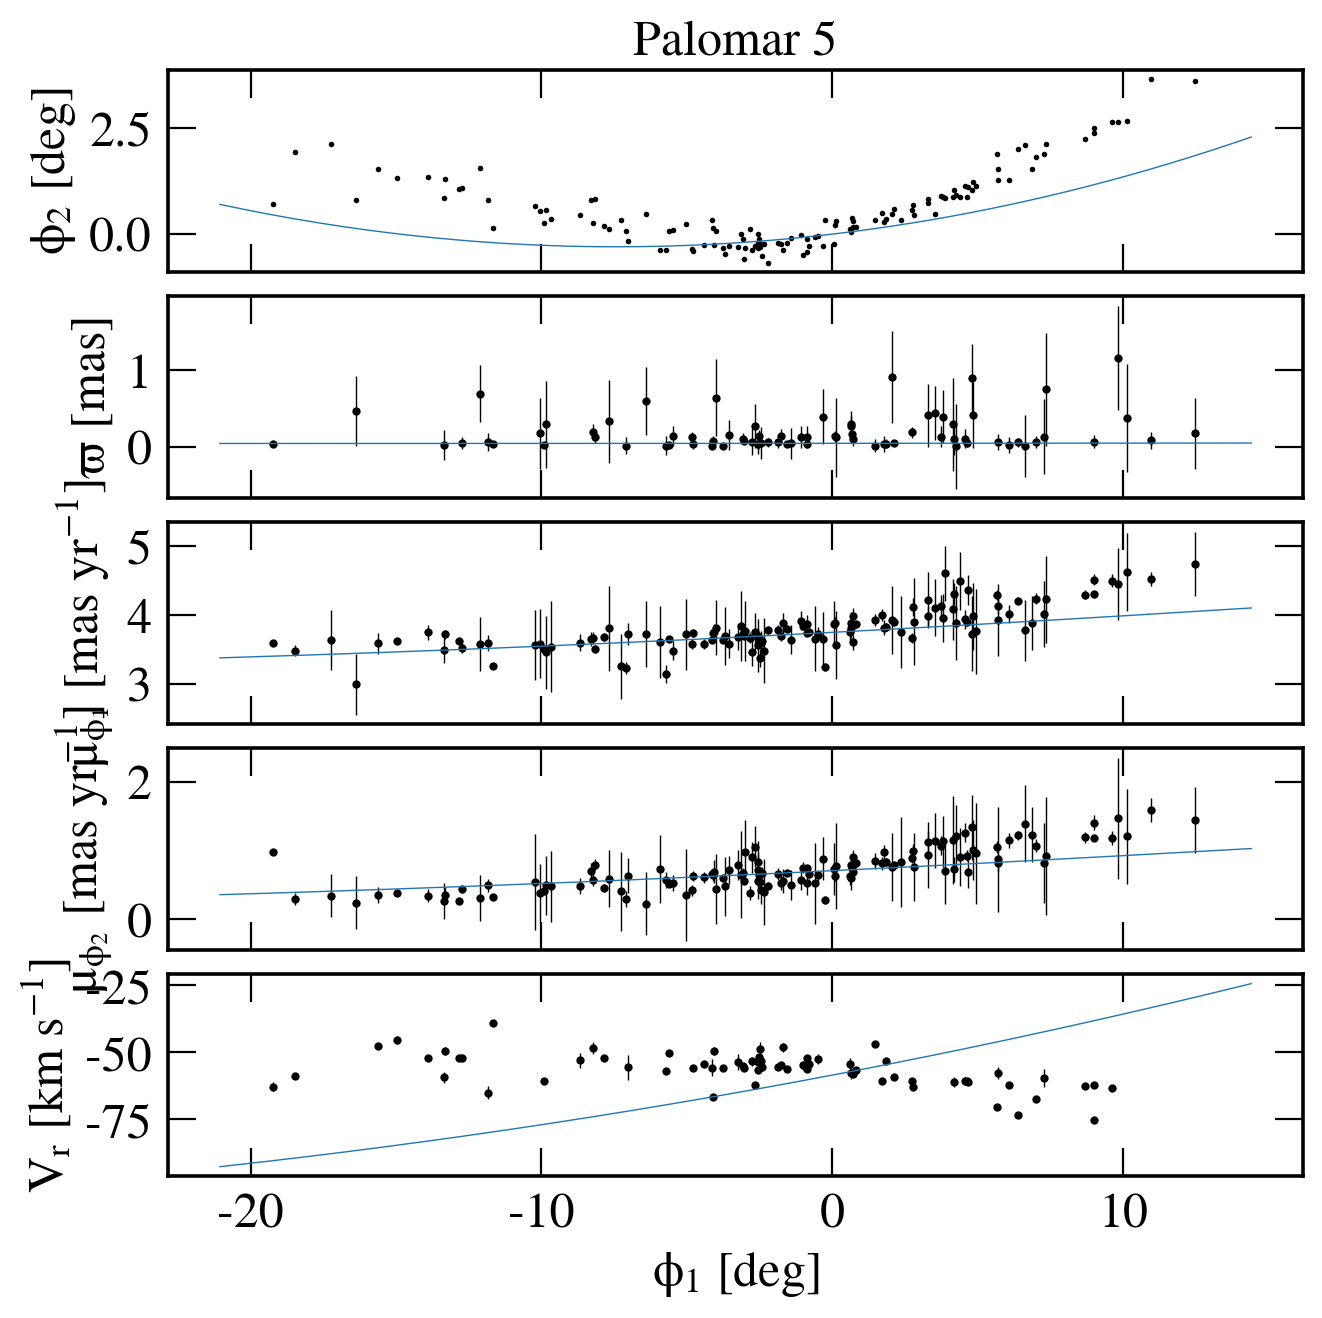

In [72]:
stream = 'NGC 6397'

for stream in dict_vasiliev.keys():

    frame = mwstreams[dict_invgalstreams[stream]].stream_frame

    ind = tgc_all['Name']==dict_vasiliev[stream]
    tgc = tgc_all[ind]

    w0_eq = coord.SkyCoord(ra=tgc['RAdeg'], dec=tgc['DEdeg'], distance=tgc['Dist'],
    pm_ra_cosdec=tgc['pmRA'], pm_dec=tgc['pmDE'], radial_velocity=tgc['HRV'])[0]
    w0_galcen = w0_eq.transform_to(galcen_frame)
    w0 = gd.PhaseSpacePosition(w0_galcen.data)

    int_time = 100*u.Myr
    if stream=='NGC 5824':
        int_time = 500*u.Myr
    elif stream=='NGC 6397':
        int_time = 10*u.Myr
    orbit = get_orbit(mw, w0, int_time)
    orbit0_fr = orbit.to_coord_frame(frame, galactocentric_frame=galcen_frame)

    p = pickle.load(open('../data/orbits/fits/{:s}.pkl'.format(stream), 'rb'))
    wangle = 180*u.deg
    row_labels = ['$\phi_2$ [deg]', '$\\varpi$ [mas]', '$\mu_{\phi_1}$ [mas yr$^{-1}$]', '$\mu_{\phi_2}$ [mas yr$^{-1}$]',
                 '$V_r$ [km s$^{-1}$]']

    ind0 = ((orbit0_fr.phi1.wrap_at(wangle)<np.max(p['c_fr'].phi1.wrap_at(wangle)) + 2*u.deg)
            & (orbit0_fr.phi1.wrap_at(wangle)>np.min(p['c_fr'].phi1.wrap_at(wangle)) - 2*u.deg)
            & (orbit0_fr.phi2<np.max(p['c_fr'].phi2) + 5*u.deg)
            & (orbit0_fr.phi2>np.min(p['c_fr'].phi2) - 5*u.deg))


    plt.close()
    fig, ax = plt.subplots(5,1, figsize=(7,7), sharex=True)

    plt.sca(ax[0])
    plt.plot(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].phi2, 'ko', mew=0, ms=2, zorder=0)
    plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.phi2[ind0], '-', lw=0.5)

    plt.title(stream, fontsize='medium')

    plt.sca(ax[1])
    ind_dist = p['c_fr'].distance<300*u.kpc
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle)[ind_dist], p['obj_data']['parallax'][ind_dist],
                 yerr=p['obj_data']['parallax_error'][ind_dist], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.distance.parallax.to(u.mas)[ind0], '-', lw=0.5, zorder=2)

    plt.sca(ax[2])
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi1_cosphi2.value,
                 yerr=p['obj_data']['pm_phi1_cosphi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.pm_phi1_cosphi2[ind0], '-', lw=0.5)

    plt.sca(ax[3])
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi2.value,
                 yerr=p['obj_data']['pm_phi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.pm_phi2[ind0], '-', lw=0.5)

    plt.sca(ax[4])
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].radial_velocity.value,
                 yerr=p['obj_data']['radial_velocity_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.radial_velocity[ind0], '-', lw=0.5)

    plt.xlabel('$\phi_1$ [deg]')

    for i in range(5):
        plt.sca(ax[i])
        plt.ylabel(row_labels[i])

    plt.tight_layout(h_pad=0)
    plt.savefig(f'../plots/diag/cluster_{stream}.png')

### Test dwarf galaxy orbits

In [77]:
td_all = Table.read('../data/NearbyGalaxies_Jan2021_PUBLIC.fits')

In [78]:
td_all

GalaxyName,RA,Dec,EB-V,dmod,dmod+,dmod-,vh,vh+,vh-,Vmag,Vmag+,Vmag-,PA,PA+,PA-,e=1-b/a,e+,e-,muVo,muVo+,muVo-,rh,rh+,rh-,sigma_s,sigma_s+,sigma_s-,vrot_s,vrot_s+,vrot_s-,MHI,sigma_g,sigma_g+,sigma_g-,vrot_g,vrot_g+,vrot_g-,[Fe/H],feh+,feh-,F,pmra,epmra+,epmra-,pmdec,epmdec+,epmdec-,References
bytes16,bytes10,bytes11,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,bytes53
*Bootes3,13:57:12.0,26:48:0.0,0.021,18.35,0.1,0.1,197.5,3.8,3.8,12.6,0.5,0.5,90.0,999.0,999.0,0.5,999.0,999.0,31.3,0.3,0.3,999.0,999.0,999.0,14.0,3.2,3.2,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-2.1,0.2,0.2,2,--,--,--,--,--,--,(14)(15)(99)
*CanisMajor,7:12:35.0,-27:40:0.0,0.264,14.29,0.3,0.3,87.0,4.0,4.0,-0.1,0.8,0.8,123.0,999.0,999.0,999.0,999.0,999.0,24.0,0.6,0.6,999.0,999.0,999.0,20.0,3.0,3.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-0.5,0.2,0.2,4,--,--,--,--,--,--,(1)(2)(95)(176)
*Cetus2,1:17:52.8,-17:25:12.0,0.02,17.1,0.1,0.1,999.0,999.0,999.0,17.4,0.7,0.7,999.0,999.0,999.0,999.0,999.0,999.0,28.55,1.2,1.2,1.9,1.0,0.5,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-1.28,0.07,0.07,5,2.84,0.05,0.07,0.46,0.06,0.07,(232)(260)(266)(267)
*Columba1,5:31:26.4,-28:1:48.0,0.025,21.3,0.22,0.22,153.7,5.0,4.8,16.8,0.2,0.2,999.0,999.0,999.0,999.0,999.0,999.0,27.95,0.7,0.7,1.9,0.5,0.4,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,9,0.19,0.06,0.06,-0.36,0.06,0.06,(232)(248)(266)(267)
*Draco2,15:52:47.6,64:33:55.0,0.018,16.67,0.05,0.05,-342.5,1.1,1.2,14.0,0.8,0.8,76.0,22.0,32.0,0.23,0.15,0.15,25.62,1.3,1.3,3.0,0.7,0.5,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-2.7,0.1,0.1,5,1.08,0.07,0.07,0.91,0.08,0.08,(225)(259)(266)(267)
*Eridanus3,2:22:45.5,-52:17:1.0,0.025,19.7,0.2,0.2,999.0,999.0,999.0,17.33,0.86,0.86,62.0,11.0,11.0,0.32,0.13,0.13,22.84,4.28,2.13,0.29,0.23,0.23,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,9,1.08,0.14,0.45,-0.49,0.17,0.13,(226)(227)(255)(266)(267)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKS2323-326,23:26:27.5,-32:23:20.0,0.015,26.72,0.09,0.09,62.0,5.0,5.0,13.5,0.2,0.2,120.0,4.0,4.0,0.1,0.01,0.01,22.9,0.2,0.2,0.9,0.1,0.1,999.0,999.0,999.0,999.0,999.0,999.0,17.0,999.0,999.0,999.0,999.0,999.0,999.0,-1.68,0.19,0.19,6,--,--,--,--,--,--,(59)(87)(122)(119)(166)(117)
UrsaMajor(1),10:34:52.8,51:55:12.0,0.02,19.93,0.1,0.1,-55.3,1.4,1.4,14.81,0.38,0.38,67.0,2.0,2.0,0.57,0.03,0.03,29.11,0.47,0.47,8.34,0.34,0.34,7.6,1.0,1.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.18,0.04,0.04,2,-0.39,0.03,0.03,-0.63,0.03,0.03,(28)(8)(98)(130)(179)(180)(255)(266)(267)


In [80]:
dict_mcconnachie = {'Sagittarius': 'SagittariusdSph ', 'Tucana III': '*Tucana3        '}

In [261]:
stream = 'Tucana III'
# stream = 'Sagittarius'

frame = mwstreams[dict_invgalstreams[stream]].stream_frame

ind = td_all['GalaxyName']==dict_mcconnachie[stream]
td = td_all[ind]

w0_eq = coord.SkyCoord(ra=td['RA'], dec=td['Dec'], unit=(u.hourangle, u.deg),
                     distance=coord.Distance(distmod=td['dmod']), radial_velocity=td['vh']*u.km/u.s,
                    pm_ra_cosdec=td['pmra']*u.mas/u.yr, pm_dec=td['pmdec']*u.mas/u.yr)[0]
int_time = 100*u.Myr

if stream=='Sagittarius':
    # Vasiliev & Belokurov (2020)
    w0_eq = coord.SkyCoord(ra=283.83125*u.deg, dec=-30.54527778*u.deg, distance=26.5*u.kpc,
                           pm_ra_cosdec=-2.7*u.mas/u.yr, pm_dec=-1.35*u.mas/u.yr, radial_velocity=142*u.km/u.s)

    int_time = 400*u.Myr

w0_galcen = w0_eq.transform_to(galcen_frame)
w0 = gd.PhaseSpacePosition(w0_galcen.data)

orbit = get_orbit(mw, w0, int_time)
orbit0_fr = orbit.to_coord_frame(frame, galactocentric_frame=galcen_frame)
print(w0_eq)
# print(td.colnames)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (359.15, -59.6, 25.234806)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-0.08, -1.62, -102.30000305)>


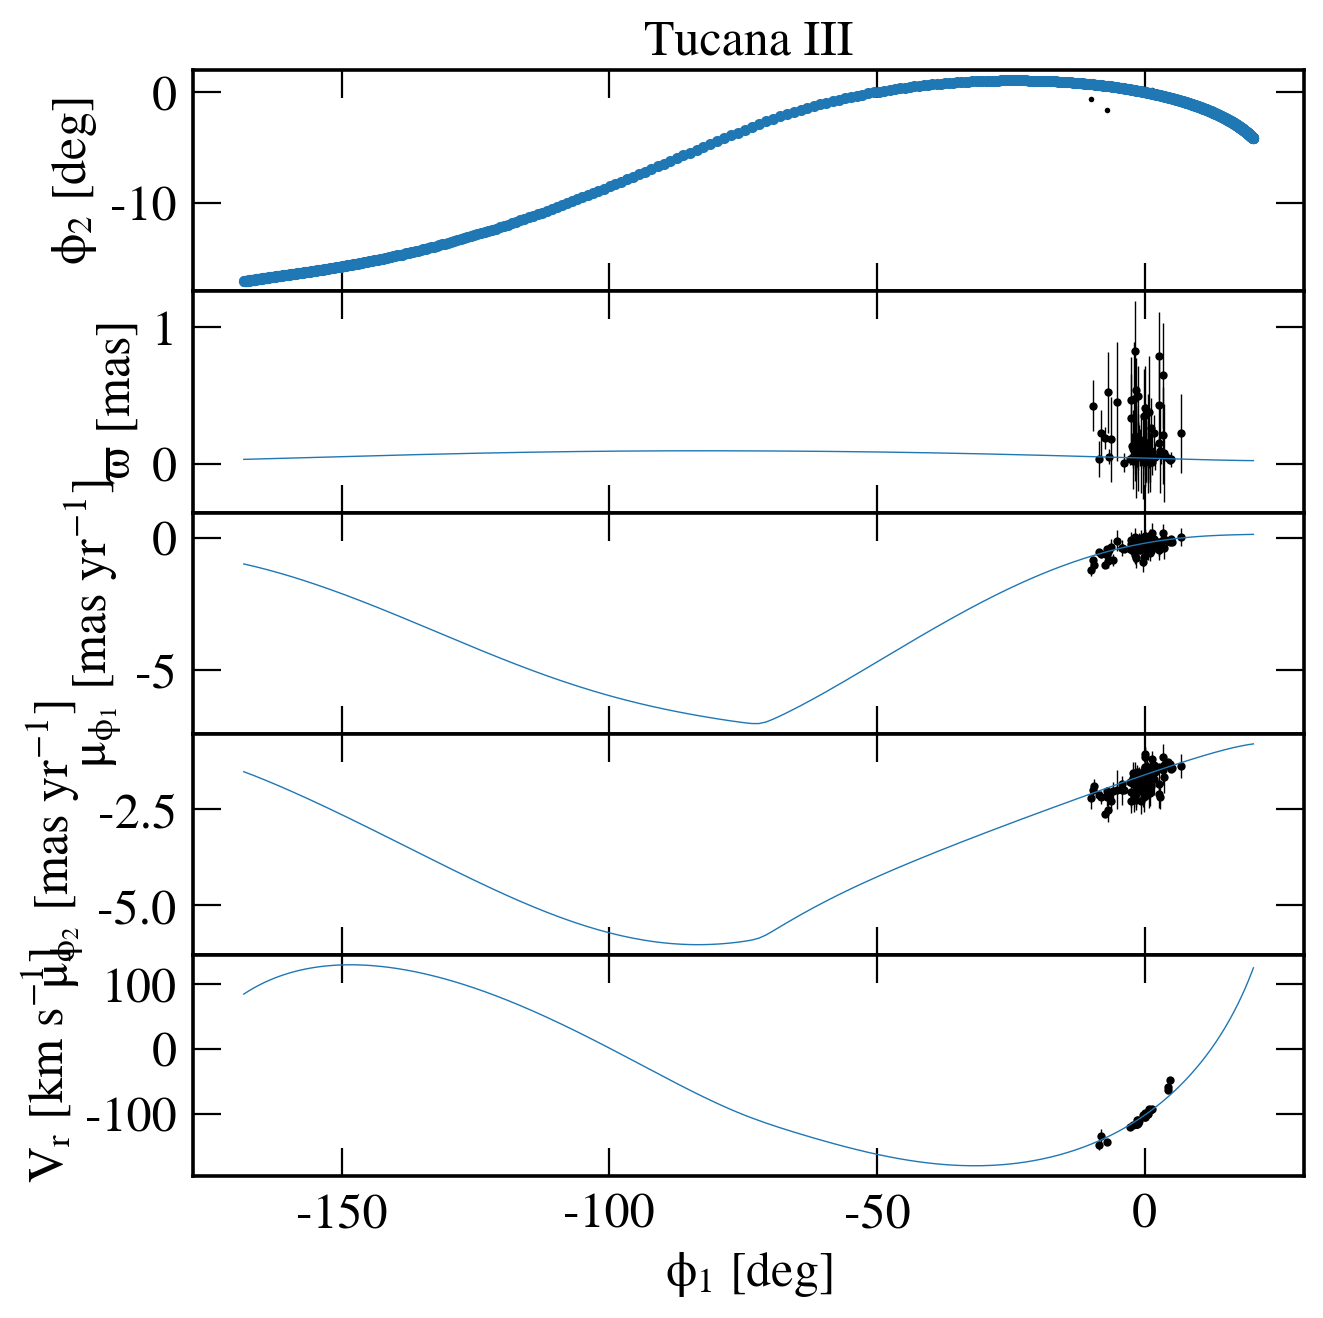

In [262]:
p = pickle.load(open('../data/orbits/fits/{:s}.pkl'.format(stream), 'rb'))
wangle = 180*u.deg
row_labels = ['$\phi_2$ [deg]', '$\\varpi$ [mas]', '$\mu_{\phi_1}$ [mas yr$^{-1}$]', '$\mu_{\phi_2}$ [mas yr$^{-1}$]',
             '$V_r$ [km s$^{-1}$]']

ind0 = ((orbit0_fr.phi1.wrap_at(wangle)<np.max(p['c_fr'].phi1.wrap_at(wangle)) + 2*u.deg)
        & (orbit0_fr.phi1.wrap_at(wangle)>np.min(p['c_fr'].phi1.wrap_at(wangle)) - 2*u.deg)
        & (orbit0_fr.phi2<np.max(p['c_fr'].phi2) + 5*u.deg)
        & (orbit0_fr.phi2>np.min(p['c_fr'].phi2) - 5*u.deg))

ind0 = (orbit.t>-400*u.Myr) & (orbit.t<790*u.Myr)

plt.close()
fig, ax = plt.subplots(5,1, figsize=(7,7), sharex=True)

plt.sca(ax[0])
plt.plot(p['c_fr'].phi1.wrap_at(wangle)[::50], p['c_fr'].phi2[::50], 'ko', mew=0, ms=2, zorder=0)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.phi2[ind0], '.', lw=0.5)

plt.title(stream, fontsize='medium')

plt.sca(ax[1])
ind_dist = p['c_fr'].distance<300*u.kpc
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle)[ind_dist], p['obj_data']['parallax'][ind_dist],
             yerr=p['obj_data']['parallax_error'][ind_dist], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.distance.parallax.to(u.mas)[ind0], '-', lw=0.5, zorder=2)

plt.sca(ax[2])
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi1_cosphi2.value,
             yerr=p['obj_data']['pm_phi1_cosphi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.pm_phi1_cosphi2[ind0], '-', lw=0.5)

plt.sca(ax[3])
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi2.value,
             yerr=p['obj_data']['pm_phi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.pm_phi2[ind0], '-', lw=0.5)

plt.sca(ax[4])
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].radial_velocity.value,
             yerr=p['obj_data']['radial_velocity_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.radial_velocity[ind0], '-', lw=0.5)

plt.xlabel('$\phi_1$ [deg]')

for i in range(5):
    plt.sca(ax[i])
    plt.ylabel(row_labels[i])

plt.tight_layout(h_pad=0)
plt.savefig(f'../plots/diag/dwarf_{stream}.png')

## Find orbit

In [926]:
def get_w0_from_p(p, phi1_init, frame):
    # At phi1 = 0.
    orbit_w0_fr = coord.SkyCoord(
        phi1=phi1_init,
        phi2=p["phi2"] * u.deg,
        distance=p["distance"] * u.kpc,
        pm_phi1_cosphi2=p["pmphi1"] * u.mas / u.yr,
        pm_phi2=p["pmphi2"] * u.mas / u.yr,
        radial_velocity=p["rv"] * u.km / u.s,
        frame=frame,
    )
    orbit_w0_galcen = orbit_w0_fr.transform_to(galcen_frame)
    return gd.PhaseSpacePosition(orbit_w0_galcen.data)

def get_orbit(mw, orbit_w0, int_time):
#     print(int_time)
    # ensure at least 50 time steps in an orbit
    dt = np.min([0.5,int_time.value/50.])
    orbit1 = mw.integrate_orbit(orbit_w0, dt=-dt, t1=0, t2=-2 * int_time)
    orbit2 = mw.integrate_orbit(orbit_w0, dt=dt, t1=0, t2=2 * int_time)
    
    orbit_xyz = np.hstack((orbit1[::-1].xyz, orbit2[1:].xyz))
    orbit_vxyz = np.hstack((orbit1[::-1].v_xyz, orbit2[1:].v_xyz))
    orbit_t = np.concatenate((orbit1[::-1].t, orbit2.t[1:]))
    orbit = gd.Orbit(orbit_xyz, orbit_vxyz, t=orbit_t)[::-1]
    return orbit

def get_orbit_from_p(mw, p, phi1_init, c_fr, max_int_time=100.):
    phi1_size = c_fr.phi1.radian.max() - c_fr.phi1.radian.min()
#     print(phi1_size)
    orbit_w0 = get_w0_from_p(p, phi1_init, c_fr.frame)
#     print(p)

    int_time = (
        (phi1_size * u.radian)
        / (np.sqrt(p["pmphi1"] ** 2 + p["pmphi2"] ** 2) * u.mas / u.yr)
    ).to_value(u.Myr)
#     print(phi1_size, int_time)
#     print(p)
#     print(c_fr.pm_phi1_cosphi2)
    int_time = np.abs(np.max([int_time, max_int_time]) * u.Myr)
#     int_time = 20*u.Myr
#     print(int_time)
    
    orbit = get_orbit(mw, orbit_w0, int_time)
    return orbit

def cut_wrapped_orbit(orbit, orbit_fr):
    idx = np.where(np.abs(np.diff(orbit_fr.phi1.wrap_at(180 * u.deg).degree)) > 180)[0]

    orbit_mask = np.ones(orbit.ntimes, dtype=bool)
    for i in idx:
        wrap_time = orbit.t[i]
        if wrap_time > 0:
            orbit_mask &= orbit.t < wrap_time
        else:
            orbit_mask &= orbit.t > wrap_time
    return orbit[orbit_mask], orbit_fr[orbit_mask]


def ln_likelihood(p, phi1_init, c_fr, data, mw, max_int_time):
    """Log-likelihood function"""
    
#     print(p)
    p = p_arr_to_dict(p)
    
    orbit = get_orbit_from_p(mw, p, phi1_init, c_fr, max_int_time=max_int_time)
    orbit_fr = orbit.to_coord_frame(c_fr.frame, galactocentric_frame=galcen_frame)
    
    # if the orbit wraps, need to cut it off at +/- 180º!
    orbit, orbit_fr = cut_wrapped_orbit(orbit, orbit_fr)
#     print(orbit_fr)
    
    interps = {}
    units = {}
    for name in ["phi2", "distance", "pm_phi1_cosphi2", "pm_phi2", "radial_velocity"]:
        # clip to the data phi1 range for interpolation
        x = orbit_fr.phi1.wrap_at(180 * u.deg).degree
#         ind_clip = ((x>np.min(c_fr.phi1.wrap_at(180*u.deg).value-2)) 
#                     & (x<np.max(c_fr.phi1.wrap_at(180*u.deg).value+2)))
#         x = x[ind_clip]
        comp = getattr(orbit_fr, name)
        idx = np.argsort(x)
        interps[name] = InterpolatedUnivariateSpline(x[idx], comp[idx], k=3)
        units[name] = comp.unit

    ll = 0.0
    for name in interps:
        if name == "phi2":
            # ensure not overfitting sky positions
            phi2_err = np.max([0.5*np.std(c_fr.phi2.value), 0.05])
#             print(phi2_err)
            err =np.ones_like(c_fr.phi2).value * phi2_err
        elif name == "distance":
            err = data["parallax_error"]
        else:
            err = data[f"{name}_error"]

        model_y = interps[name](c_fr.phi1.wrap_at(180 * u.deg).degree)

        if name == "distance":
            y = data["parallax"]
            model_y = c_fr.distance.parallax.to_value(u.mas)
#             print(y, c_fr.distance.parallax)
        else:
            y = getattr(c_fr, name).to_value(units[name])
        
        ind_finite = np.isfinite(y) & (err>0)
#         print(name, np.size(model_y), np.size(y))
        if (np.sum(ind_finite)>0):
#             print(name, np.sum(ind_finite), np.nansum(-0.5 * (model_y[ind_finite] - y[ind_finite]) ** 2 / err[ind_finite]**2)/np.sum(ind_finite))
#             if name=='phi2':
#                 print(np.sum((model_y-y)**2), model_y, y)
# #                 print(err)
            ll += np.nansum(-0.5 * (model_y[ind_finite] - y[ind_finite]) ** 2 / err[ind_finite]**2)/np.sum(ind_finite)

    return -ll


def p_arr_to_dict(p):
    return {
        "phi2": p[0],
        "distance": p[1],
        "pmphi1": p[2],
        "pmphi2": p[3],
        "rv": p[4],
    }


def run_orbit_fit(gaia_data, frame, N_init_dist=6, progenitor='', phi1_init=0*u.deg, sigma_vr=0., sigma_pm1=0.,
                  sigma_pm2=0., max_int_time=100., verbose=False):
    
    ########################
    # Generate data object #
    ########################
    # input distances
    _dist = gaia_data.get_distance(allow_negative=True)
    _dist[~np.isfinite(_dist)] = 100 * u.Mpc  # put them very far away if missing
    
    # input radial velocities
    ind_vel = np.isfinite(gaia_data['Vr'])
    _vel = gaia_data['Vr']
    _vel[~ind_vel] = 0*u.km/u.s

    c = gaia_data.get_skycoord(distance=_dist, radial_velocity=_vel)
    c_fr = c.transform_to(frame)
    c_fr.radial_velocity[~ind_vel] = np.nan

    C, _ = gaia_data.get_cov(coords=["pmra", "pmdec"])
    C_pm_fr = gc.transform_pm_cov(c, C, frame)
    pm1_err = np.sqrt(C_pm_fr[:, 0, 0])
    pm2_err = np.sqrt(C_pm_fr[:, 1, 1])
    obj_data = {
        "parallax": gaia_data.parallax.value,
        "parallax_error": gaia_data.parallax_error.value,
        "pm_phi1_cosphi2_error": np.sqrt(pm1_err**2 + sigma_pm1**2),
        "pm_phi2_error": np.sqrt(pm2_err**2 + sigma_pm2**2),
        "radial_velocity_error": np.sqrt(gaia_data.Vr_err.value**2 + sigma_vr**2),
    }
    
    #############
    # Get orbit #
    #############
    
    if len(progenitor)>0:
        # just get progenitor orbit
        if progenitor in dict_vasiliev.keys():
            # globular cluster stream
            tgc_all = Table.read('../data/gc_best.fits')
            ind = tgc_all['Name']==dict_vasiliev[stream]
            tgc = tgc_all[ind]

            w0_eq = coord.SkyCoord(ra=tgc['RAdeg'], dec=tgc['DEdeg'], distance=tgc['Dist'],pm_ra_cosdec=tgc['pmRA'],
                                   pm_dec=tgc['pmDE'], radial_velocity=tgc['HRV'])[0]

            max_int_time = 100
            if progenitor=='NGC 5824':
                max_int_time = 500
            elif progenitor=='NGC 6397':
                max_int_time = 10
        
        elif progenitor=='Tucana III':
            td_all = Table.read('../data/NearbyGalaxies_Jan2021_PUBLIC.fits')
            ind = td_all['GalaxyName']==dict_mcconnachie[progenitor]
            td = td_all[ind]

            w0_eq = coord.SkyCoord(ra=td['RA'], dec=td['Dec'], unit=(u.hourangle, u.deg),
                                 distance=coord.Distance(distmod=td['dmod']), radial_velocity=td['vh']*u.km/u.s,
                                pm_ra_cosdec=td['pmra']*u.mas/u.yr, pm_dec=td['pmdec']*u.mas/u.yr)[0]
            max_int_time = 100

        elif stream=='Sagittarius':
            # Vasiliev & Belokurov (2020)
            w0_eq = coord.SkyCoord(ra=283.83125*u.deg, dec=-30.54527778*u.deg, distance=26.5*u.kpc,
                                   pm_ra_cosdec=-2.7*u.mas/u.yr, pm_dec=-1.35*u.mas/u.yr,
                                   radial_velocity=142*u.km/u.s)
            max_int_time = 400
        
        w0_fr = w0_eq.transform_to(c_fr)    
        phi1_init = w0_fr.phi1
        pbest = {'phi2': w0_fr.phi2.deg,
                 'distance': w0_eq.distance.to(u.kpc).value,
                 'pmphi1': w0_fr.pm_phi1_cosphi2.to(u.mas/u.yr).value,
                 'pmphi2': w0_fr.pm_phi2.to(u.mas/u.yr).value,
                 'rv': w0_eq.radial_velocity.to(u.km/u.s).value}
        
    else:
        # fit orbit to stream
        # get trial orbit from the data
        idx = np.argsort(np.abs(c_fr.phi1.wrap_at(180 * u.deg).degree - phi1_init.value))
        phi2 = np.nanmedian(c_fr.phi2.to_value(u.deg)[idx][:8])
        pm_phi1 = np.nanmean(c_fr.pm_phi1_cosphi2[idx][:8])
        pm_phi2 = np.nanmean(c_fr.pm_phi2[idx][:8])

        # try to get a better guess at radial velocity
        ind_center = np.abs(c_fr.phi1.wrap_at(180*u.deg) - phi1_init)<10*u.deg
        if np.any(np.isfinite(gaia_data['Vr'][ind_center])):
            rv = np.nanmedian(gaia_data['Vr'][ind_center])
        else:
            rv = np.nanmedian(gaia_data['Vr'])
        if not np.isfinite(rv):
            rv = 0.*u.km/u.s

        # Try orbit-fitting optimization from N_init_dist different initial distance values,
        # then pick the best one after optimization:
        init_dists = np.geomspace(1, 40, N_init_dist)
#         init_dists = [20.,]
        reses = []
        for d0 in init_dists:
            p0 = {
                "phi2": phi2,
                "distance": d0,
                "pmphi1": pm_phi1.value,
                "pmphi2": pm_phi2.value,
                "rv": rv.value,
            }
            if verbose: print(p0)
            try:
                res = minimize(
                    ln_likelihood,
                    list(p0.values()),
                    bounds=[[-15, 15], [0.05, 50], [-200, 200], [-200, 200], [-700, 700]],
                    args=(phi1_init, c_fr, obj_data, mw, max_int_time),
                    method="L-BFGS-B",
                    options={"ftol": 1e-10, "gtol": 1e-10},
                )
            except Exception as err:
                print(f"Orbit fit failed with an exception: ")
                print(err)
                continue

            if not res.success:
                continue

            reses.append(res)

        if len(reses) == 0:
            print(f"Stream failed: {res.nit}")
            return None
        elif len(reses) == 1:
            res = reses[0]
        else:
            i = np.argmin([r.fun for r in reses])
            res = reses[i]

        pbest = p_arr_to_dict(res.x)

    # Best-fit orbit
    orbit = get_orbit_from_p(mw, pbest, phi1_init, c_fr, max_int_time)
    orbit_fr = orbit.to_coord_frame(c_fr.frame, galactocentric_frame=galcen_frame)
    
    # Store stuff:
    this_data = {}
    this_data["c_fr"] = c_fr
    this_data["obj_data"] = obj_data
    this_data["p"] = [phi1_init.to(u.deg).value,] + list(pbest.values())
#     this_data["p"] = pbest
    this_data["orbit"] = orbit
    this_data["orbit_fr"] = orbit_fr
    return this_data


In [915]:
# default stream setup
setup_stream = {x:{'progenitor':'', 'phi1_init':0*u.deg, 'sigma_vr':0., 'max_int_time':100.,
                  'sigma_pm1':0., 'sigma_pm2':0.} for x in published}

# custom stream setups

setup_stream['C-11']['max_int_time'] = 30
setup_stream['C-11']['sigma_pm1'] = 0.2
setup_stream['C-11']['sigma_pm2'] = 0.2
setup_stream['C-11']['sigma_vr'] = 20

setup_stream['C-12']['max_int_time'] = 30
setup_stream['C-12']['sigma_pm1'] = 0.2
setup_stream['C-12']['sigma_pm2'] = 0.2
setup_stream['C-12']['sigma_vr'] = 20

setup_stream['C-13']['phi1_init'] = 5*u.deg
setup_stream['C-13']['max_int_time'] = 30
setup_stream['C-13']['sigma_pm1'] = 0.1
setup_stream['C-13']['sigma_pm2'] = 0.2
setup_stream['C-13']['sigma_vr'] = 100

setup_stream['C-24']['phi1_init'] = 6*u.deg
setup_stream['C-24']['max_int_time'] = 30
setup_stream['C-24']['sigma_pm1'] = 0.2
setup_stream['C-24']['sigma_pm2'] = 0.5
setup_stream['C-24']['sigma_vr'] = 50

setup_stream['C-7']['max_int_time'] = 30
setup_stream['C-7']['sigma_pm1'] = 1
setup_stream['C-7']['sigma_pm2'] = 0.5
setup_stream['C-7']['sigma_vr'] = 30

setup_stream['C-9']['phi1_init'] = 7*u.deg
setup_stream['C-9']['max_int_time'] = 30
setup_stream['C-9']['sigma_pm1'] = 1
setup_stream['C-9']['sigma_pm2'] = 1
setup_stream['C-9']['sigma_vr'] = 10

setup_stream['Cetus-Palca']['phi1_init'] = 74*u.deg

setup_stream['Gaia-11']['max_int_time'] = 30
setup_stream['Gaia-11']['sigma_vr'] = 50

setup_stream['Gaia-8']['sigma_vr'] = 20

setup_stream['GD-1']['phi1_init'] = -40*u.deg
setup_stream['GD-1']['sigma_vr'] = 5.

setup_stream['Kwando']['phi1_init'] = -10*u.deg
setup_stream['Kwando']['max_int_time'] = 50
setup_stream['Kwando']['sigma_vr'] = 20

setup_stream['Wukong']['sigma_vr'] = 20.
setup_stream['Wukong']['sigma_pm1'] = 1
setup_stream['Wukong']['sigma_pm2'] = 1

setup_stream['New-2']['phi1_init'] = 10*u.deg
setup_stream['New-2']['max_int_time'] = 30
setup_stream['New-2']['sigma_vr'] = 10
setup_stream['New-2']['sigma_pm1'] = 10
setup_stream['New-2']['sigma_pm2'] = 10

setup_stream['New-18']['phi1_init'] = -4*u.deg
setup_stream['New-18']['max_int_time'] = 20
setup_stream['New-18']['sigma_pm1'] = 1
setup_stream['New-18']['sigma_pm2'] = 1
setup_stream['New-18']['sigma_vr'] = 100

setup_stream['New-20']['max_int_time'] = 2
setup_stream['New-20']['sigma_pm1'] = 5
setup_stream['New-20']['sigma_pm2'] = 1
setup_stream['New-20']['sigma_vr'] = 10

setup_stream['New-21']['max_int_time'] = 30
setup_stream['New-21']['sigma_vr'] = 50

setup_stream['New-22']['max_int_time'] = 30
setup_stream['New-22']['sigma_vr'] = 35

setup_stream['New-23']['max_int_time'] = 30
setup_stream['New-23']['sigma_pm1'] = 5
setup_stream['New-23']['sigma_pm2'] = 1
setup_stream['New-23']['sigma_vr'] = 35

setup_stream['New-24']['max_int_time'] = 20
setup_stream['New-24']['sigma_vr'] = 41

setup_stream['New-25']['max_int_time'] = 50
setup_stream['New-25']['sigma_pm1'] = 1
setup_stream['New-25']['sigma_pm2'] = 1
setup_stream['New-25']['sigma_vr'] = 10

setup_stream['New-26']['max_int_time'] = 20
setup_stream['New-26']['sigma_vr'] = 20

setup_stream['New-27']['max_int_time'] = 30
setup_stream['New-27']['sigma_vr'] = 50

setup_stream['New-3']['phi1_init'] = -10*u.deg
setup_stream['New-3']['max_int_time'] = 1
setup_stream['New-3']['sigma_pm1'] = 5
setup_stream['New-3']['sigma_pm2'] = 5

setup_stream['New-5']['phi1_init'] = -25*u.deg
setup_stream['New-5']['max_int_time'] = 50
setup_stream['New-5']['sigma_pm1'] = 5
setup_stream['New-5']['sigma_pm2'] = 5
setup_stream['New-5']['sigma_vr'] = 50

setup_stream['New-8']['phi1_init'] = 2.5*u.deg
setup_stream['New-8']['max_int_time'] = 2
setup_stream['New-8']['sigma_pm1'] = 10
setup_stream['New-8']['sigma_pm2'] = 10
setup_stream['New-8']['sigma_vr'] = 20

setup_stream['Orphan-Chenab']['phi1_init'] = 75*u.deg

for stream in list(dict_vasiliev.keys()) + ['Tucana III', 'Sagittarius']:
    setup_stream[stream]['progenitor'] = stream

### Run an individual stream

In [921]:
# load data
stream = 'Cetus-Palca'
tin = Table.read('../data/members/unique/{:s}.fits'.format(stream))
if stream=='Orphan-Chenab':
    ceq = coord.ICRS(ra=tin['ra'], dec=tin['dec'])
    ind = ceq.transform_to(coord.Galactic()).b>0
    tin = tin[ind]
gin = GaiaData(tin, radial_velocity_colname='Vr', radial_velocity_error_colname='Vr_err')
frame = mwstreams[dict_invgalstreams[stream]].stream_frame

# get orbit
data = run_orbit_fit(gin, frame, verbose=True, **setup_stream[stream])

# store orbit
with open('../data/orbits/fits/{:s}.pkl'.format(stream), 'wb') as f:
    pickle.dump(data, f)

{'phi2': -8.28452670487567, 'distance': 20.0, 'pmphi1': 0.6106960097867636, 'pmphi2': 0.7607125801267236, 'rv': 96.92}


In [922]:
data['p'], len(data['orbit_fr'].phi1), data.keys(), np.size(data['obj_data']['parallax'])

([74.0,
  -9.23887073931449,
  6.3253918866069485,
  0.4276730610230015,
  0.7909489130327724,
  99.1304643188037],
 800,
 dict_keys(['c_fr', 'obj_data', 'p', 'orbit', 'orbit_fr']),
 25)

In [923]:
p0 = {'phi2': -0.23711784774780753, 'distance': 10.0, 'pmphi1': 2.5923640658444804, 
      'pmphi2': -5.0850214799028235, 'rv': -12.46}
orbit0 = get_orbit_from_p(mw, p0, data['p'][0]*u.deg, data['c_fr'])
orbit0_fr = orbit0.to_coord_frame(data['c_fr'], galactocentric_frame=galcen_frame)

In [924]:
print(ln_likelihood(list(p0.values()), data['p'][0]*u.deg, data['c_fr'], data['obj_data'], mw, max_int_time))
print(ln_likelihood(list(data['p'][1:]), data['p'][0]*u.deg, data['c_fr'], data['obj_data'], mw, max_int_time))

13474.293100812985
29.720080299766455


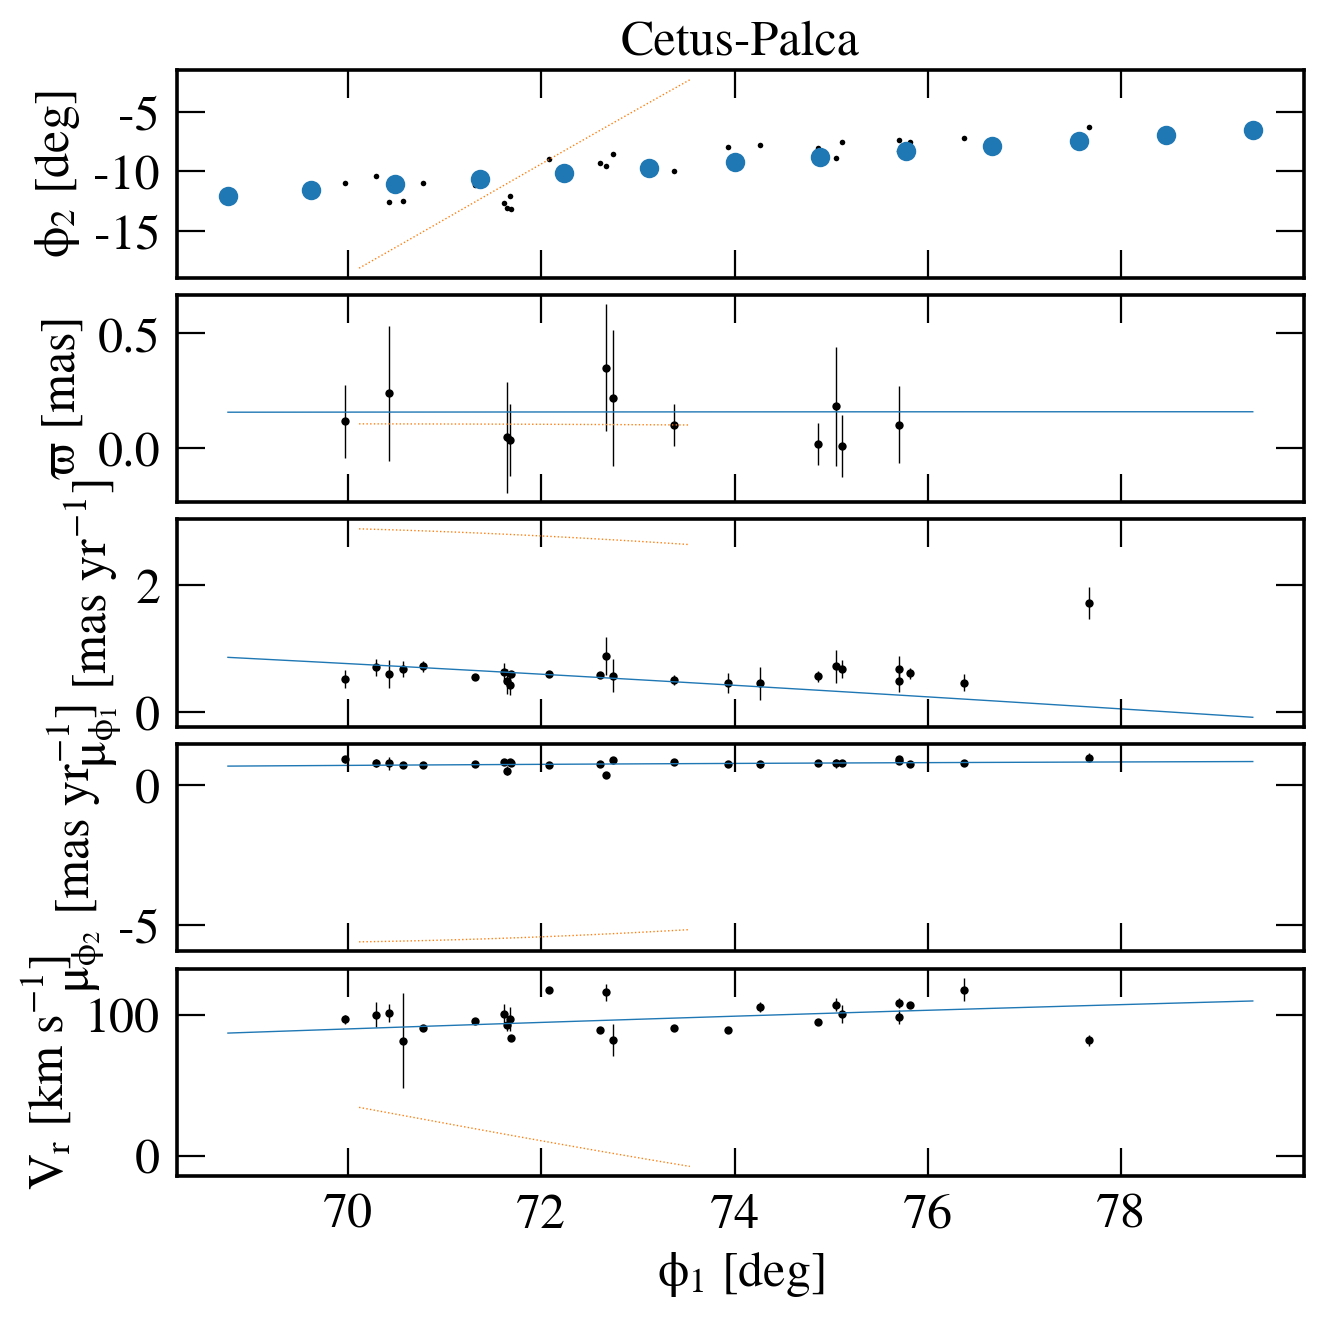

In [925]:
# plot
p = pickle.load(open('../data/orbits/fits/{:s}.pkl'.format(stream), 'rb'))
ind_segment = ((p['orbit_fr'].phi1.wrap_at(wangle)<np.max(p['c_fr'].phi1.wrap_at(wangle)) + 2*u.deg)
               & (p['orbit_fr'].phi1.wrap_at(wangle)>np.min(p['c_fr'].phi1.wrap_at(wangle)) - 2*u.deg)
              & (p['orbit_fr'].phi2<np.max(p['c_fr'].phi2) + 5*u.deg)
              & (p['orbit_fr'].phi2>np.min(p['c_fr'].phi2) - 5*u.deg))
ind0 = ((orbit0_fr.phi1.wrap_at(wangle)<np.max(p['c_fr'].phi1.wrap_at(wangle)) + 2*u.deg)
        & (orbit0_fr.phi1.wrap_at(wangle)>np.min(p['c_fr'].phi1.wrap_at(wangle)) - 2*u.deg)
        & (orbit0_fr.phi2<np.max(p['c_fr'].phi2) + 5*u.deg)
        & (orbit0_fr.phi2>np.min(p['c_fr'].phi2) - 5*u.deg))

plt.close()
fig, ax = plt.subplots(5,1, figsize=(7,7), sharex=True)

plt.sca(ax[0])
plt.plot(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].phi2, 'ko', mew=0, ms=2, zorder=0)
plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].phi2[ind_segment], 'o', lw=0.5)
# plt.plot(p['orbit_fr'].phi1.wrap_at(wangle), p['orbit_fr'].phi2, 'o', lw=0.5)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.phi2[ind0], ':', lw=0.5)

# plt.plot(p['orbit_fr'].phi1.wrap_at(wangle), p['orbit_fr'].phi2, '-', lw=0.5)
# plt.plot(orbit0_fr.phi1.wrap_at(wangle), orbit0_fr.phi2, ':', lw=0.5)

plt.title(stream, fontsize='medium')

plt.sca(ax[1])
ind_dist = p['c_fr'].distance<300*u.kpc
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle)[ind_dist], p['obj_data']['parallax'][ind_dist],
             yerr=p['obj_data']['parallax_error'][ind_dist], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].distance.parallax.to(u.mas)[ind_segment],
         '-', lw=0.5, zorder=1)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.distance.parallax.to(u.mas)[ind0], ':', lw=0.5, zorder=2)

plt.sca(ax[2])
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi1_cosphi2.value,
             yerr=p['obj_data']['pm_phi1_cosphi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi1_cosphi2[ind_segment],
         '-', lw=0.5, zorder=1)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.pm_phi1_cosphi2[ind0], ':', lw=0.5)

plt.sca(ax[3])
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi2.value,
             yerr=p['obj_data']['pm_phi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi2[ind_segment],
         '-', lw=0.5, zorder=1)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.pm_phi2[ind0], ':', lw=0.5)

plt.sca(ax[4])
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].radial_velocity.value,
             yerr=p['obj_data']['radial_velocity_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].radial_velocity[ind_segment],
         '-', lw=0.5, zorder=1)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.radial_velocity[ind0], ':', lw=0.5)

plt.xlabel('$\phi_1$ [deg]')

for i in range(5):
    plt.sca(ax[i])
    plt.ylabel(row_labels[i])

plt.tight_layout(h_pad=0)

### Run all streams

In [927]:
nstart = 0
# for e, stream in enumerate(published[nstart:]):
for e, stream in enumerate(['ATLAS-Aliqa Uma', 'Cetus-Palca']):
    print(nstart+e, stream)
    t1 = time.time()
    
    # load data
    tin = Table.read('../data/members/unique/{:s}.fits'.format(stream))
    if stream=='Orphan-Chenab':
        ceq = coord.ICRS(ra=tin['ra'], dec=tin['dec'])
        ind = ceq.transform_to(coord.Galactic()).b>0
        tin = tin[ind]
    gin = GaiaData(tin, radial_velocity_colname='Vr', radial_velocity_error_colname='Vr_err')
    frame = mwstreams[dict_invgalstreams[stream]].stream_frame

    # get orbit
    data = run_orbit_fit(gin, frame, **setup_stream[stream])
    
    # store orbit
    with open('../data/orbits/fits/{:s}.pkl'.format(stream), 'wb') as f:
        pickle.dump(data, f)
    
    t2 = time.time()
    dt = (t2 - t1)*u.s
    print('{:d} {:.0f}'.format(len(tin), dt))

0 ATLAS-Aliqa Uma
245 68 s
1 Cetus-Palca
25 39 s


### Diagnostic plots

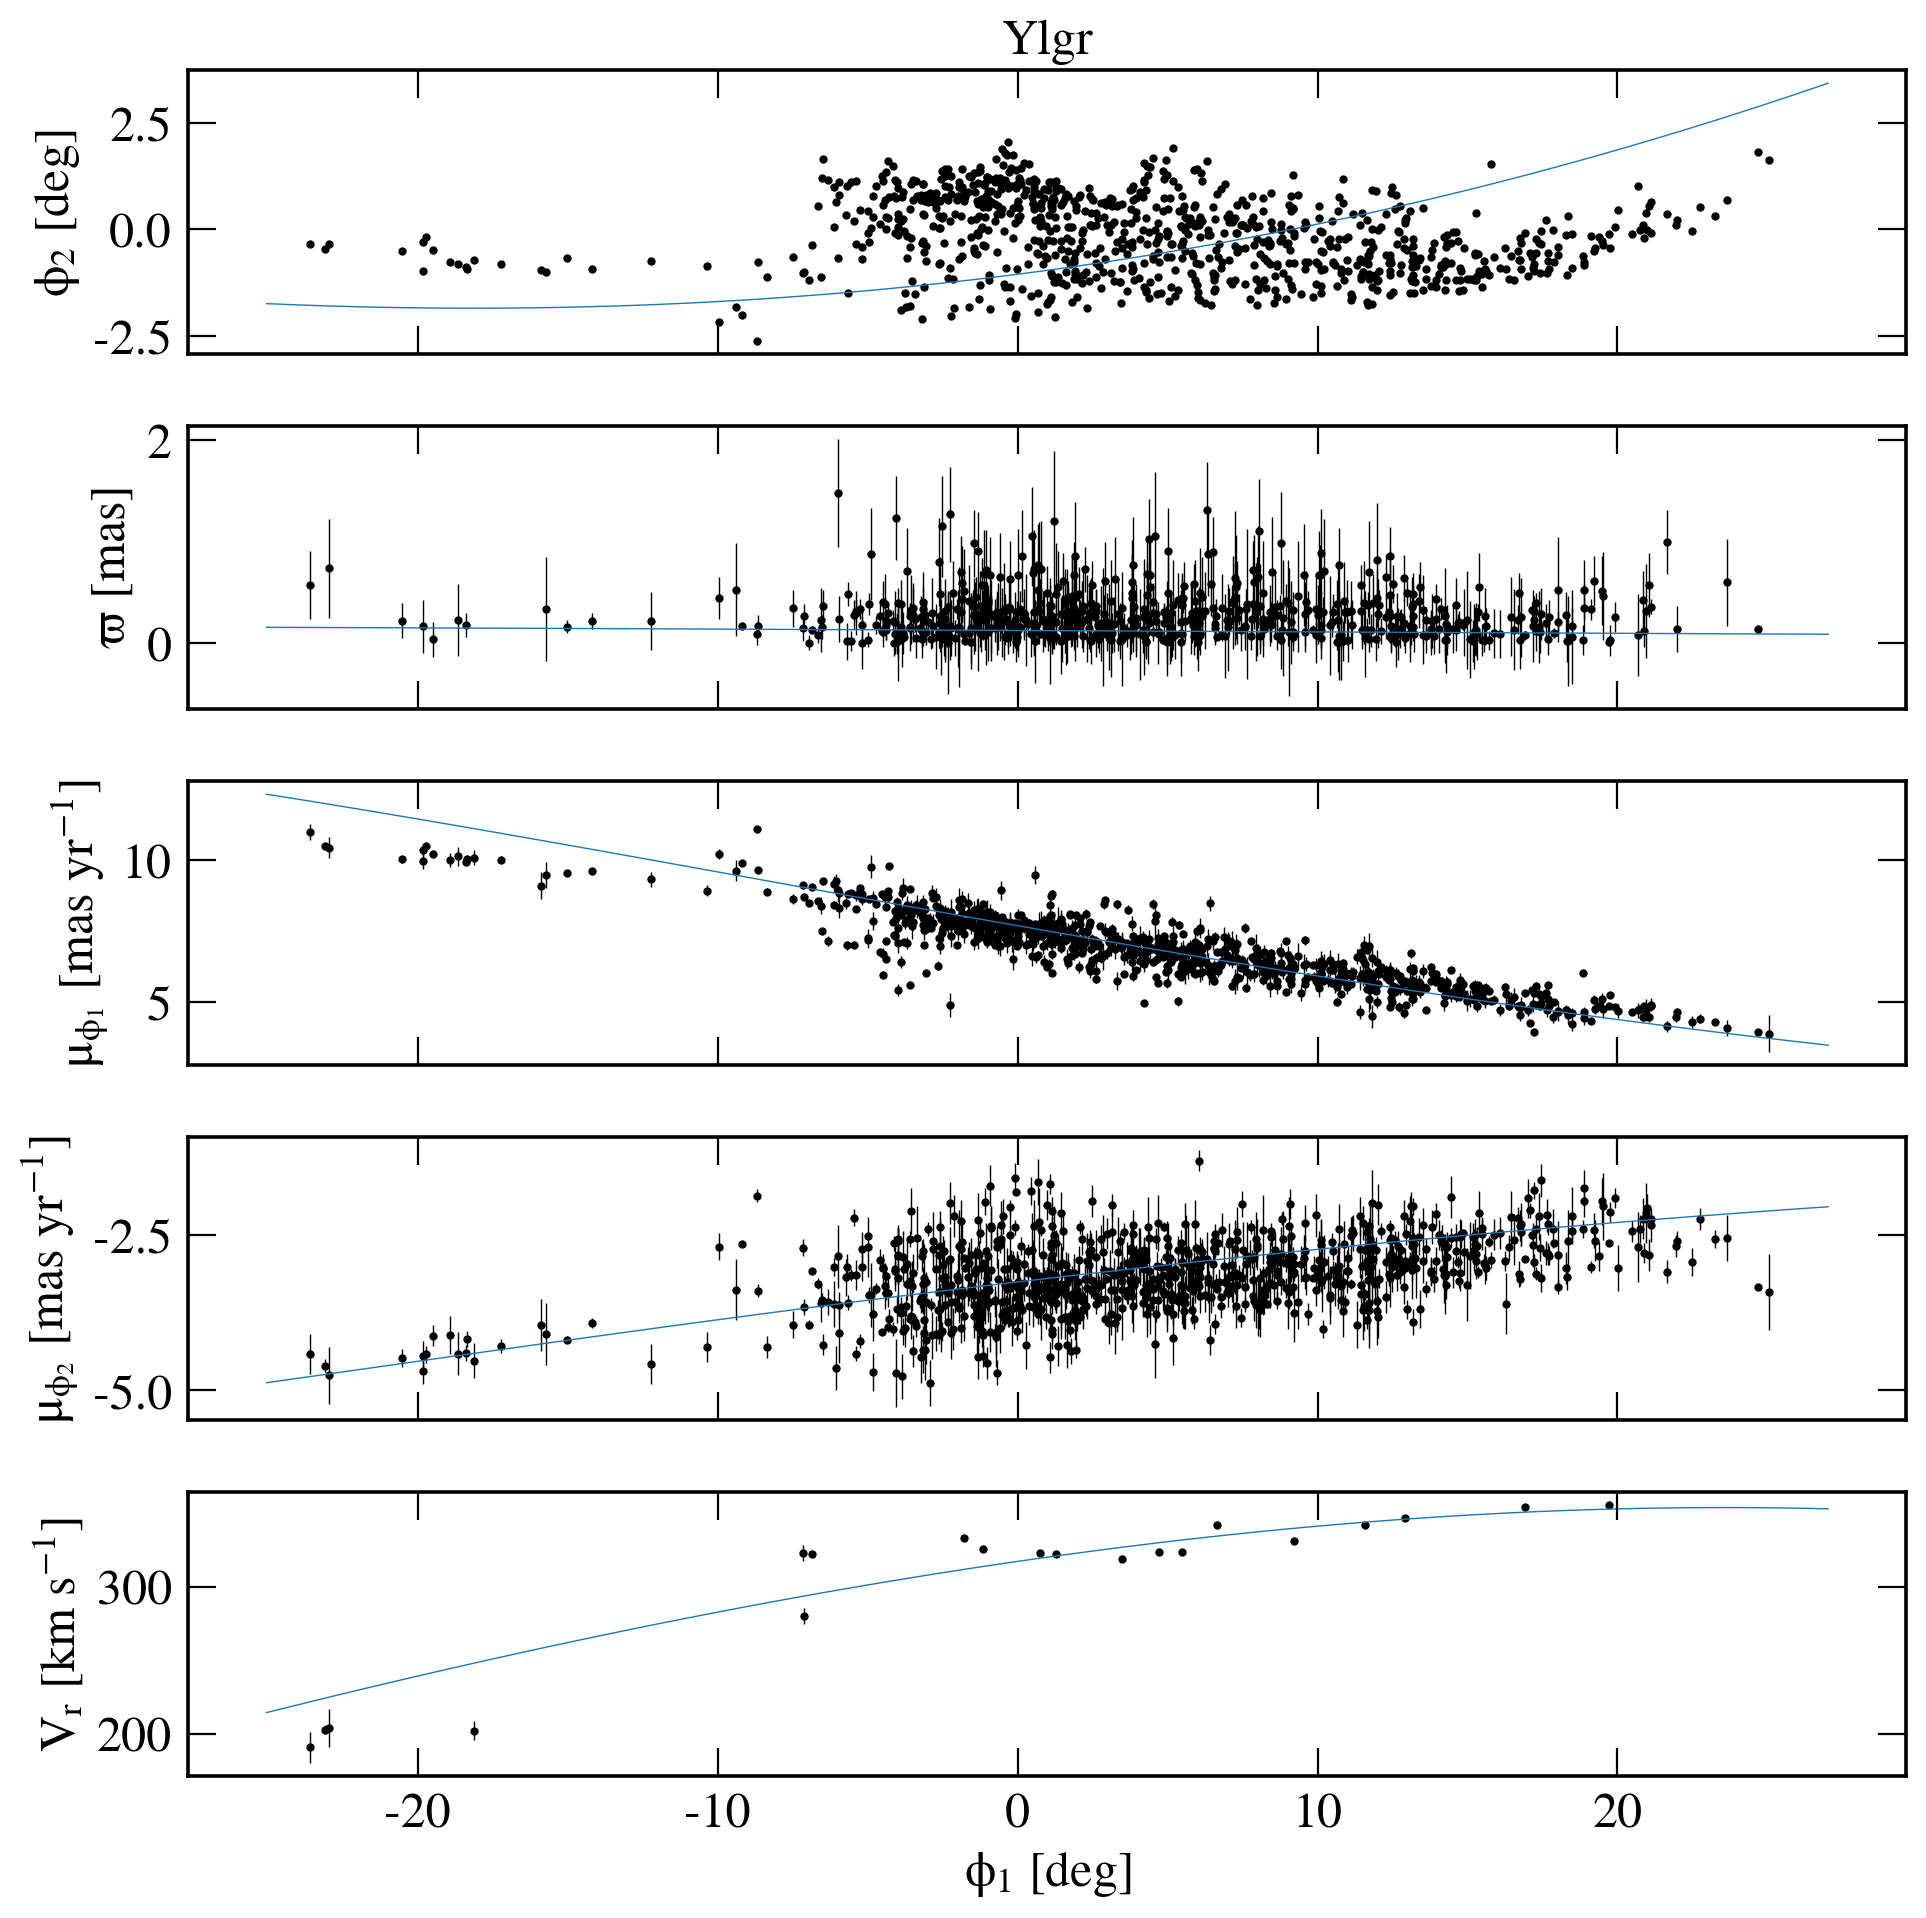

In [928]:
# individual stream orbit fits
wangle = 180*u.deg
row_labels = ['$\phi_2$ [deg]', '$\\varpi$ [mas]', '$\mu_{\phi_1}$ [mas yr$^{-1}$]', '$\mu_{\phi_2}$ [mas yr$^{-1}$]',
             '$V_r$ [km s$^{-1}$]']

pp = PdfPages('../plots/orbit_fits_diagnostics.pdf')

for stream in published[:]:
    p = pickle.load( open('../data/orbits/fits/{:s}.pkl'.format(stream), 'rb'))
    ind_segment = ((p['orbit_fr'].phi1.wrap_at(wangle)<np.max(p['c_fr'].phi1.wrap_at(wangle)) + 2*u.deg)
                   & (p['orbit_fr'].phi1.wrap_at(wangle)>np.min(p['c_fr'].phi1.wrap_at(wangle)) - 2*u.deg)
                  & (p['orbit_fr'].phi2<np.max(p['c_fr'].phi2) + 2*u.deg)
                  & (p['orbit_fr'].phi2>np.min(p['c_fr'].phi2) - 2*u.deg))
    
    plt.close()
    fig, ax = plt.subplots(5,1, figsize=(10,10), sharex=True)
    
    plt.sca(ax[0])
    plt.plot(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].phi2, 'ko', mew=0, ms=3)
    plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].phi2[ind_segment], '-', lw=0.5)
    plt.title(stream, fontsize='medium')
    
    plt.sca(ax[1])
    ind_dist = p['c_fr'].distance<300*u.kpc
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle)[ind_dist], p['obj_data']['parallax'][ind_dist],
                 yerr=p['obj_data']['parallax_error'][ind_dist], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].distance.parallax.to(u.mas)[ind_segment],
             '-', lw=0.5, zorder=1)
    
    plt.sca(ax[2])
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi1_cosphi2.value,
                 yerr=p['obj_data']['pm_phi1_cosphi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi1_cosphi2[ind_segment],
             '-', lw=0.5, zorder=1)
    
    plt.sca(ax[3])
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi2.value,
                 yerr=p['obj_data']['pm_phi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi2[ind_segment],
             '-', lw=0.5, zorder=1)
    
    plt.sca(ax[4])
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].radial_velocity.value,
                 yerr=p['obj_data']['radial_velocity_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].radial_velocity[ind_segment],
             '-', lw=0.5, zorder=1)
    plt.xlabel('$\phi_1$ [deg]')
    
    for i in range(5):
        plt.sca(ax[i])
        plt.ylabel(row_labels[i])
    
    plt.tight_layout()
    pp.savefig()
    
pp.close()

92 23 4


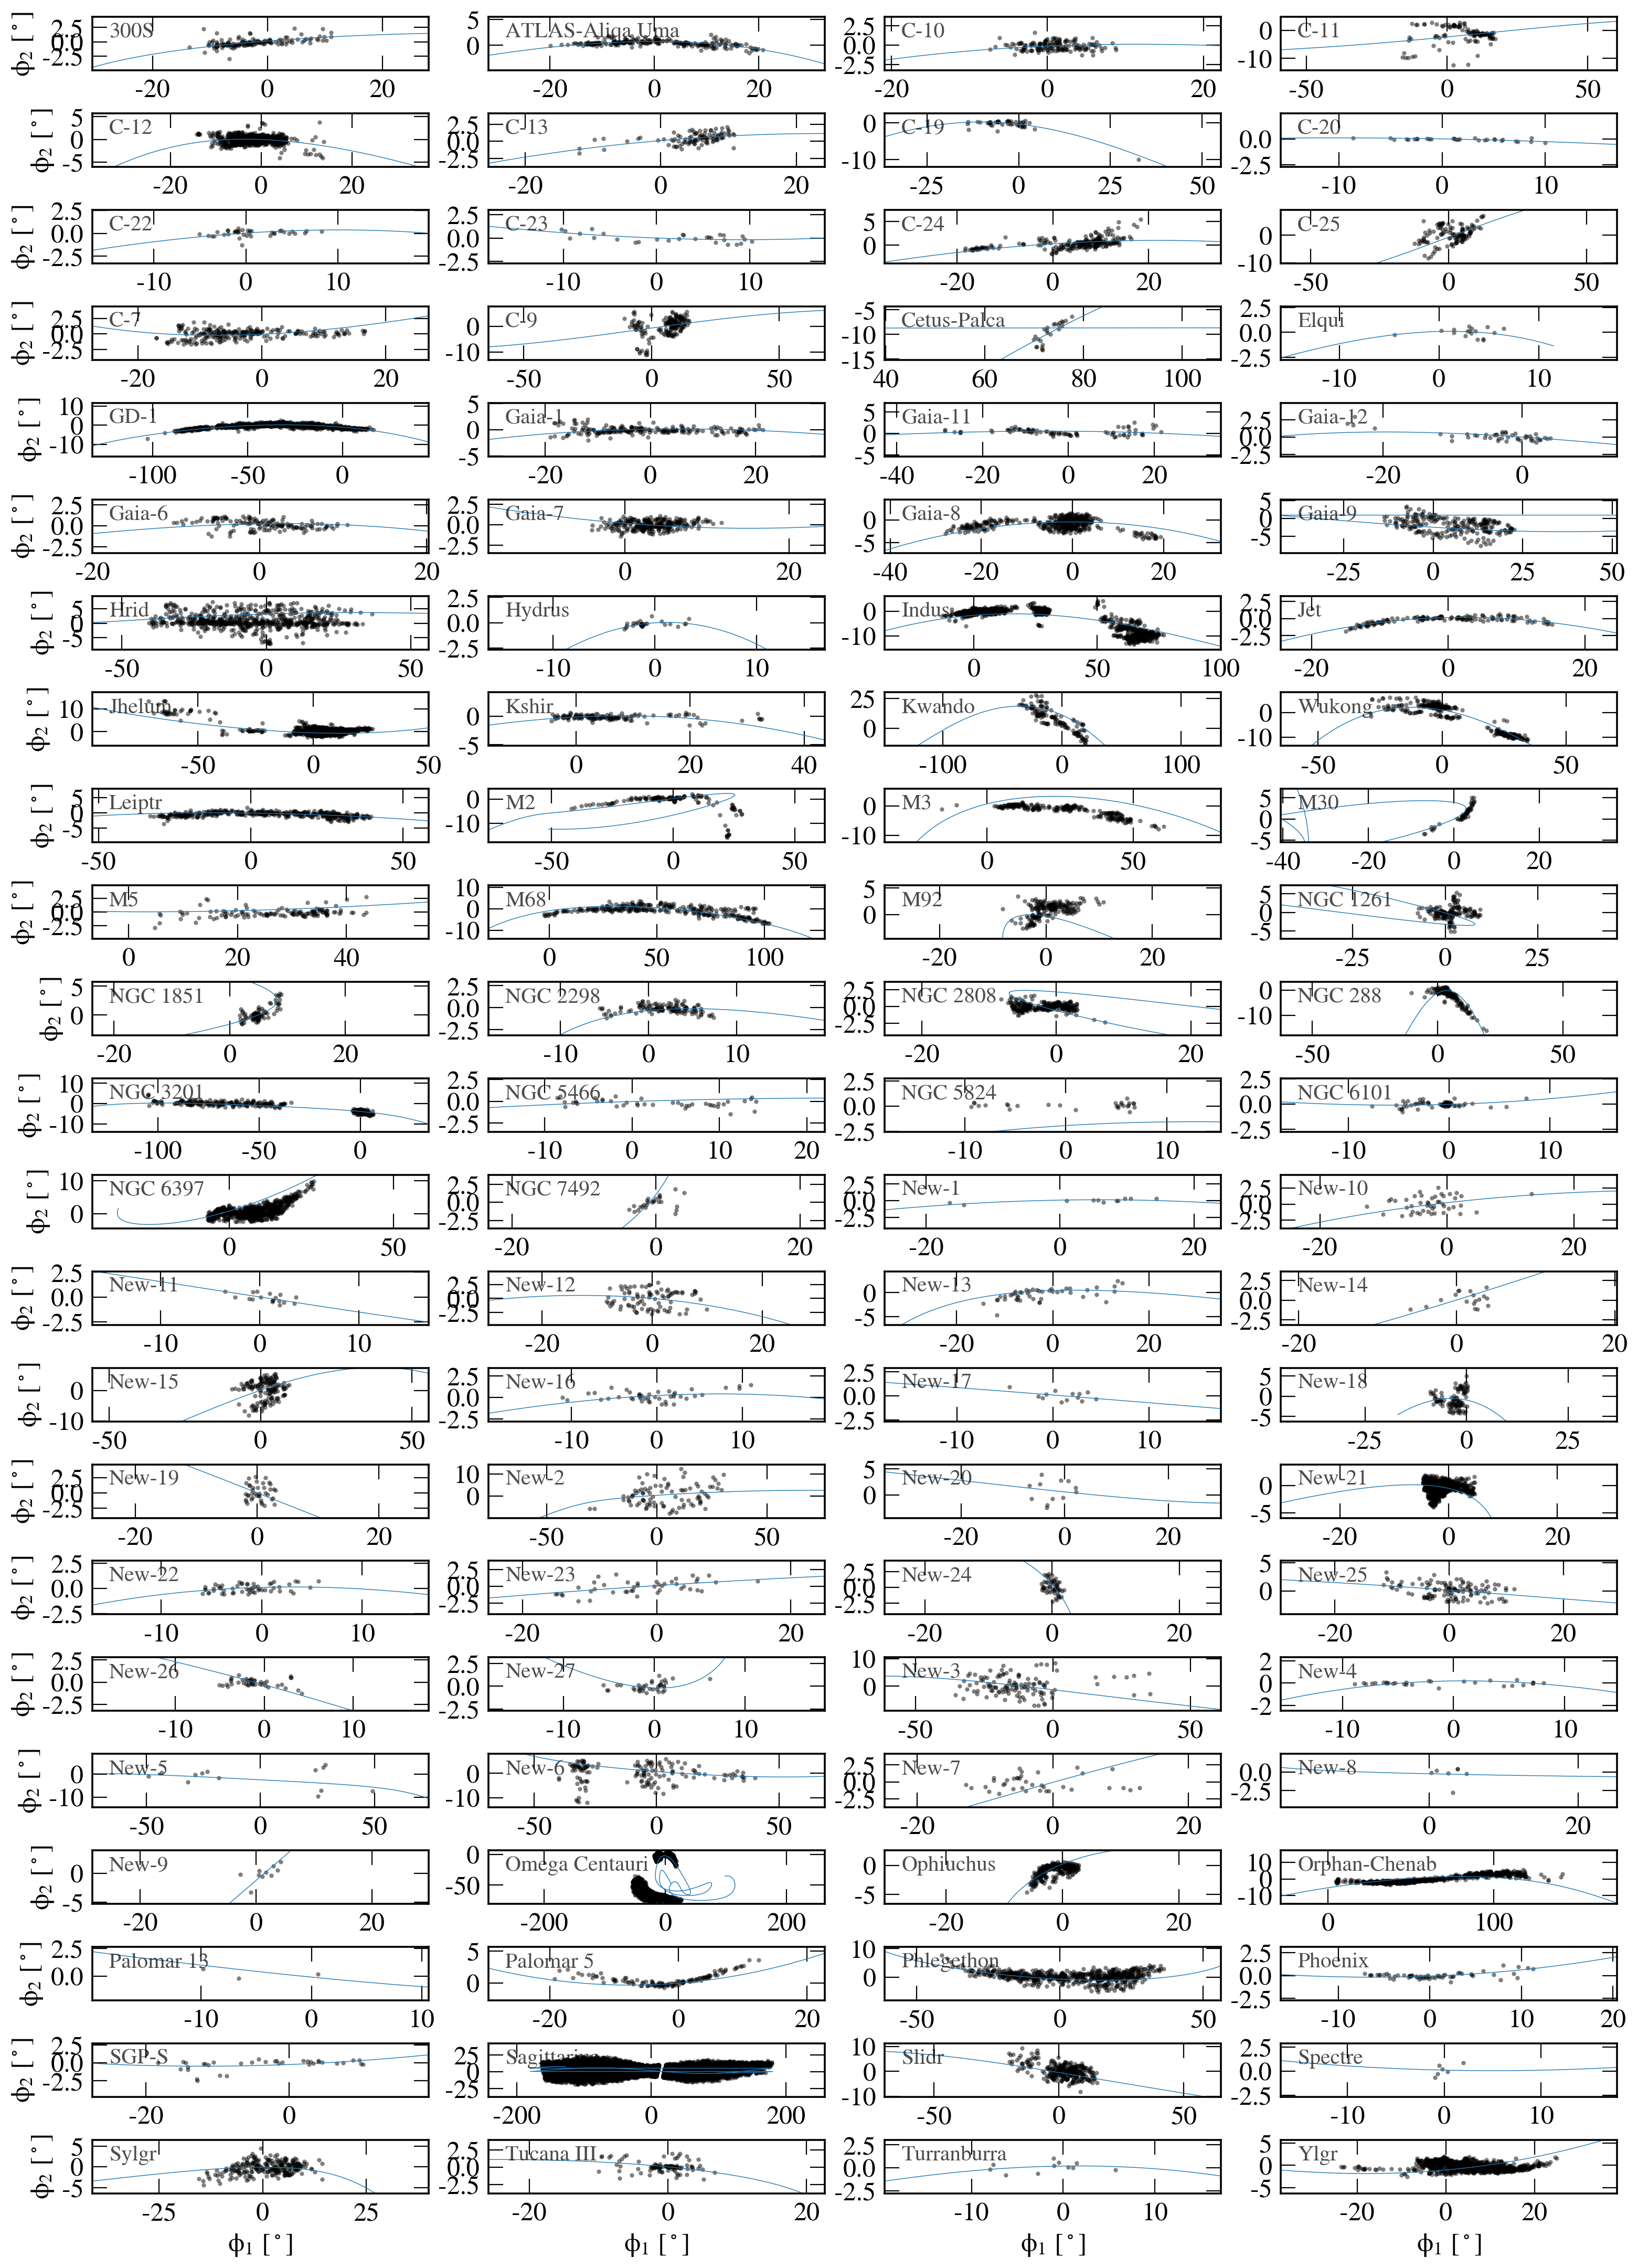

In [929]:
# summary figure
# set up figure geometry
nstream = len(published)
ncol = 4
nrow = int(np.ceil(nstream/ncol))
print(nstream, nrow, ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(16,22))

for i in range(nstream):
    irow = i // ncol
    icol = i % ncol
    plt.sca(ax[irow][icol])
    
    # load stream
    stream = published[i]
    p = pickle.load( open('../data/orbits/fits/{:s}.pkl'.format(stream), 'rb'))
    
    # plot
    plt.plot(p['c_fr'].phi1.wrap_at(180*u.deg), p['c_fr'].phi2, 'ko', mew=0, ms=3, alpha=0.5, rasterized=True)
    plt.plot(p['orbit_fr'].phi1.wrap_at(180*u.deg), p['orbit_fr'].phi2, '-', lw=0.5)
    
    plt.xlim(np.min(p['c_fr'].phi1.value)-2, np.max(p['c_fr'].phi1.value)+2)
    plt.ylim(np.min(p['c_fr'].phi2.value)-2, np.max(p['c_fr'].phi2.value)+2)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.text(0.05, 0.9, published[i], transform=plt.gca().transAxes, va='top', fontsize='small', alpha=0.7)

# labels
for i in range(nrow):
    plt.sca(ax[i][0])
    plt.ylabel('$\phi_2$ [$^\circ$]')

for i in range(ncol):
    plt.sca(ax[nrow-1][i])
    plt.xlabel('$\phi_1$ [$^\circ$]')

# plt.sca(ax[nrow-1][ncol-1])
# plt.axis('off')
# plt.text(0.5, 1, '$\phi_1$ [$^\circ$]', transform=plt.gca().transAxes, va='top', ha='center')
    
plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('../plots/all_members_sky_orbit.png', dpi=300)

In [385]:
pall = pickle.load( open('../data/stream-orbit-fits.pkl', 'rb'))
psum = pickle.load( open('../data/all_stream_summary_data.pkl', 'rb'))

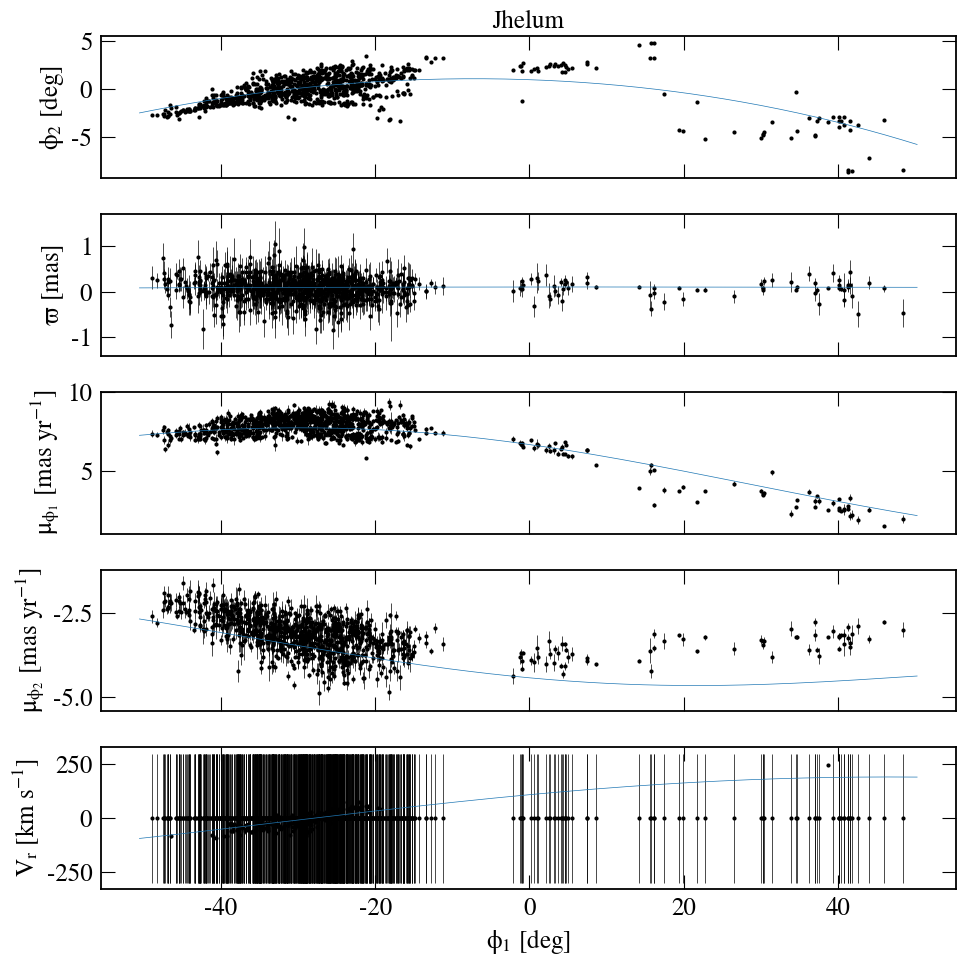

In [402]:
# OLD individual stream orbit fits
wangle = 180*u.deg
row_labels = ['$\phi_2$ [deg]', '$\\varpi$ [mas]', '$\mu_{\phi_1}$ [mas yr$^{-1}$]', '$\mu_{\phi_2}$ [mas yr$^{-1}$]',
             '$V_r$ [km s$^{-1}$]']

pp = PdfPages('../plots/old_orbit_fits_diagnostics.pdf')

nold = len(pall.keys())
# nold = 2

for i in range(nold):
    if (i+1) in pall.keys():
        name = psum['name'][psum['ibata2023_sID']==i+1][0]
        p = pall[i+1]
        ind_segment = ((p['orbit_fr'].phi1.wrap_at(wangle)<np.max(p['c_fr'].phi1.wrap_at(wangle)) + 2*u.deg)
                       & (p['orbit_fr'].phi1.wrap_at(wangle)>np.min(p['c_fr'].phi1.wrap_at(wangle)) - 2*u.deg)
                      & (p['orbit_fr'].phi2<np.max(p['c_fr'].phi2) + 2*u.deg)
                      & (p['orbit_fr'].phi2>np.min(p['c_fr'].phi2) - 2*u.deg))

        plt.close()
        fig, ax = plt.subplots(5,1, figsize=(10,10), sharex=True)

        plt.sca(ax[0])
        plt.plot(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].phi2, 'ko', mew=0, ms=3)
        plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].phi2[ind_segment], '-', lw=0.5)
        plt.title(name, fontsize='medium')

        plt.sca(ax[1])
        ind_dist = p['c_fr'].distance<300*u.kpc
        plt.errorbar(p['c_fr'].phi1.wrap_at(wangle)[ind_dist], p['obj_data']['parallax'][ind_dist],
                     yerr=p['obj_data']['parallax_error'][ind_dist], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
        plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].distance.parallax.to(u.mas)[ind_segment],
                 '-', lw=0.5, zorder=1)

        plt.sca(ax[2])
        plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi1_cosphi2.value,
                     yerr=p['obj_data']['pm_phi1_cosphi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
        plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi1_cosphi2[ind_segment],
                 '-', lw=0.5, zorder=1)

        plt.sca(ax[3])
        plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi2.value,
                     yerr=p['obj_data']['pm_phi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
        plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi2[ind_segment],
                 '-', lw=0.5, zorder=1)

        plt.sca(ax[4])
        plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].radial_velocity.value,
                     yerr=p['obj_data']['radial_velocity_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
        plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].radial_velocity[ind_segment],
                 '-', lw=0.5, zorder=1)
        plt.xlabel('$\phi_1$ [deg]')

        for i in range(5):
            plt.sca(ax[i])
            plt.ylabel(row_labels[i])

        plt.tight_layout()
        pp.savefig()
    
pp.close()

## Orbital summaries

### Control points in ICRS

In [954]:
# define table
tcontrol = Table(names=('name', 'ra', 'dec', 'distance', 'pmra', 'pmdec', 'Vr'),
                dtype=('str', 'float', 'float', 'float', 'float', 'float', 'float'),
                units=(None, u.deg, u.deg, u.kpc, u.mas/u.yr, u.mas/u.yr, u.km/u.s))

# fill rows
for stream in published[:]:
    p = pickle.load( open('../data/orbits/fits/{:s}.pkl'.format(stream), 'rb'))

    c = coord.SkyCoord(phi1=p['p'][0]*u.deg, phi2=p['p'][1]*u.deg, distance=p['p'][2]*u.kpc,
                      pm_phi1_cosphi2=p['p'][3]*u.mas/u.yr, pm_phi2=p['p'][4]*u.mas/u.yr,
                      radial_velocity=p['p'][5]*u.km/u.s, frame=p['c_fr'])
    ceq = c.transform_to(coord.ICRS())
    
    tcontrol.add_row([stream, ceq.ra, ceq.dec, ceq.distance, ceq.pm_ra_cosdec, ceq.pm_dec, ceq.radial_velocity])

In [955]:
tcontrol

name,ra,dec,distance,pmra,pmdec,Vr
,deg,deg,kpc,mas / yr,mas / yr,km / s
str15,float64,float64,float64,float64,float64,float64
300S,157.53075993872147,15.474858868958902,14.57002892031368,-3.5376922403116247,-3.0274054683274523,296.7913059624446
ATLAS-Aliqa Uma,20.293258082767785,-27.07856857689201,20.650564588019005,-0.03466679532027617,-0.97900559173618,-107.03425492397811
C-10,145.99607492750735,1.795422392327991,8.205007955394423,-0.5676348780194557,0.7228817492607146,46.06907779862649
C-11,109.35115283113686,46.22115218969786,6.873541419416133,6.188170242374492,-1.5263686713034286,-44.904203730043065
C-12,96.4506291478248,-29.821318329939928,11.068698495457802,-0.6403795801949531,-1.4510933847201861,294.68030267511915
C-13,35.66478825356473,38.58877319158014,8.198159879891218,3.340748638379775,1.8461084620868702,-102.6346125995457
...,...,...,...,...,...,...
Slidr,163.7422959571504,7.731887795557992,3.1613521720273488,-23.160504102584362,-6.215034181955547,-94.95331824578744


### Long orbits

In [957]:
from functools import partial

In [958]:
def pot(R):
    return mw.energy([R, 0, 0]*u.kpc).value[0]

pot_vec = np.vectorize(pot)

def Lcirc(Etot, R):
    return -R*((2*(Etot - pot_vec(R)))**0.5) 

def maxLcirc(Etot):
    optfunc = partial(Lcirc,Etot)
    res = minimize(optfunc, np.array([0.1]), method='BFGS')
    return np.abs(res.fun)


In [976]:
# define table
torb = Table(names=('rperi', 'rapo', 'T', 'ecc', 'Etot', 'L', 'Lx', 'Ly', 'Lz', 'Lperp', 'Lmax', 'circLz'),
                units=(u.kpc, u.kpc, u.Myr, None, u.kpc**2*u.Myr**-2, u.kpc**2*u.Myr**-1, u.kpc**2*u.Myr**-1
                      , u.kpc**2*u.Myr**-1, u.kpc**2*u.Myr**-1, u.kpc**2*u.Myr**-1, u.kpc**2*u.Myr**-1, None))

# orbit integration setup
dt = 0.5*u.Myr
T = 5*u.Gyr
Nstep = int((T/dt).decompose())
c0_all = coord.ICRS(ra=tcontrol['ra'], dec=tcontrol['dec'], distance=tcontrol['distance'],
                   pm_ra_cosdec=tcontrol['pmra'], pm_dec=tcontrol['pmdec'], radial_velocity=tcontrol['Vr'])

# fill rows
for e, stream in enumerate(published[:]):
    # integrate long orbit
    c0 = c0_all[e]
    w0 = gd.PhaseSpacePosition(c0.transform_to(galcen_frame).data)
    orbit = mw.integrate_orbit(w0, dt=dt, n_steps=Nstep)
    
    # calculate orbital properties
    rperi = orbit.pericenter()
    rapo = orbit.apocenter()
    period = orbit.physicsspherical.estimate_period()['r'][0]
    
    ecc = orbit.eccentricity()
    Etot = orbit.energy()[0]
    L = orbit.angular_momentum()[:,0]
    Ltot = np.linalg.norm(L)
    Lperp = np.sqrt(L[0]**2 + L[1]**2)
    
    maxLcirc_vec = np.vectorize(maxLcirc)
    maxLcirc_arr = maxLcirc_vec(np.linspace(-0.265, 0, 1000))
    
    Lmax = (np.interp(orbit.energy()[0].value, np.linspace(-0.265, 0, 1000), maxLcirc_arr)) * Ltot.unit
    circLz = np.abs(L[2]/Lmax)
    
    # store
    row = [rperi, rapo, period, ecc, Etot, Ltot, L[0], L[1], L[2], Lperp, Lmax, circLz]
    torb.add_row(row)
    print(e, stream, row)


0 300S [<Quantity 4.02407643 kpc>, <Quantity 45.36313593 kpc>, <Quantity 581.83482143 Myr>, <Quantity 0.83703974>, <Quantity -0.07983416 kpc2 / Myr2>, <Quantity 1.96592248 kpc2 / Myr>, <Quantity 0.88030849 kpc2 / Myr>, <Quantity -1.74906166 kpc2 / Myr>, <Quantity 0.17518982 kpc2 / Myr>, <Quantity 1.95810106 kpc2 / Myr>, <Quantity 5.77977891 kpc2 / Myr>, <Quantity 0.03031082>]
1 ATLAS-Aliqa Uma [<Quantity 12.4059365 kpc>, <Quantity 38.08444477 kpc>, <Quantity 565.78125 Myr>, <Quantity 0.50858218>, <Quantity -0.08185261 kpc2 / Myr2>, <Quantity 4.121034 kpc2 / Myr>, <Quantity 3.67243877 kpc2 / Myr>, <Quantity -0.4436387 kpc2 / Myr>, <Quantity -1.81639736 kpc2 / Myr>, <Quantity 3.69913798 kpc2 / Myr>, <Quantity 5.52368319 kpc2 / Myr>, <Quantity 0.32883808>]
2 C-10 [<Quantity 13.44395557 kpc>, <Quantity 20.15030775 kpc>, <Quantity 356.73076923 Myr>, <Quantity 0.1996279>, <Quantity -0.10043055 kpc2 / Myr2>, <Quantity 3.5145778 kpc2 / Myr>, <Quantity -1.45507492 kpc2 / Myr>, <Quantity 0.20870

/usr/local/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


7 C-20 [<Quantity 24.18506131 kpc>, <Quantity 166.41797632 kpc>, <Quantity nan Myr>, <Quantity 0.74622586>, <Quantity -0.03691183 kpc2 / Myr2>, <Quantity 9.06101986 kpc2 / Myr>, <Quantity 8.04961864 kpc2 / Myr>, <Quantity 2.00375232 kpc2 / Myr>, <Quantity -3.64564085 kpc2 / Myr>, <Quantity 8.29526272 kpc2 / Myr>, <Quantity 17.70787068 kpc2 / Myr>, <Quantity 0.20587686>]
8 C-22 [<Quantity 10.31510954 kpc>, <Quantity 18.83676671 kpc>, <Quantity 308.403125 Myr>, <Quantity 0.29231934>, <Quantity -0.10646461 kpc2 / Myr2>, <Quantity 2.88460137 kpc2 / Myr>, <Quantity -1.51923508 kpc2 / Myr>, <Quantity 2.2047072 kpc2 / Myr>, <Quantity -1.07336667 kpc2 / Myr>, <Quantity 2.67746318 kpc2 / Myr>, <Quantity 3.27562136 kpc2 / Myr>, <Quantity 0.32768338>]
9 C-23 [<Quantity 12.66923843 kpc>, <Quantity 19.40964893 kpc>, <Quantity 340.12912088 Myr>, <Quantity 0.21011983>, <Quantity -0.10249085 kpc2 / Myr2>, <Quantity 3.30765971 kpc2 / Myr>, <Quantity -1.02559445 kpc2 / Myr>, <Quantity -3.12872194 kpc2 /

29 Kshir [<Quantity 13.87905674 kpc>, <Quantity 16.09418244 kpc>, <Quantity 314.88333333 Myr>, <Quantity 0.07390345>, <Quantity -0.10573381 kpc2 / Myr2>, <Quantity 3.22455665 kpc2 / Myr>, <Quantity 1.6250302 kpc2 / Myr>, <Quantity -0.44356929 kpc2 / Myr>, <Quantity 2.74959792 kpc2 / Myr>, <Quantity 1.68448119 kpc2 / Myr>, <Quantity 3.32424679 kpc2 / Myr>, <Quantity 0.82713411>]
30 Kwando [<Quantity 14.57185747 kpc>, <Quantity 33.43285619 kpc>, <Quantity 529.94097222 Myr>, <Quantity 0.39289889>, <Quantity -0.08453437 kpc2 / Myr2>, <Quantity 4.39396904 kpc2 / Myr>, <Quantity 3.39207584 kpc2 / Myr>, <Quantity 1.50808775 kpc2 / Myr>, <Quantity -2.35084172 kpc2 / Myr>, <Quantity 3.71221055 kpc2 / Myr>, <Quantity 5.20404776 kpc2 / Myr>, <Quantity 0.45173331>]
31 Wukong [<Quantity 8.34060426 kpc>, <Quantity 14.71104076 kpc>, <Quantity 240.69210526 Myr>, <Quantity 0.27635496>, <Quantity -0.11713712 kpc2 / Myr2>, <Quantity 2.27292824 kpc2 / Myr>, <Quantity -2.05432554 kpc2 / Myr>, <Quantity 0.6

51 New-10 [<Quantity 8.96928721 kpc>, <Quantity 10.44017166 kpc>, <Quantity 196.83666667 Myr>, <Quantity 0.07578184>, <Quantity -0.12583837 kpc2 / Myr2>, <Quantity 2.2106519 kpc2 / Myr>, <Quantity -0.45246577 kpc2 / Myr>, <Quantity 1.02925705 kpc2 / Myr>, <Quantity -1.90338816 kpc2 / Myr>, <Quantity 1.12431995 kpc2 / Myr>, <Quantity 2.25311509 kpc2 / Myr>, <Quantity 0.84478071>]
52 New-11 [<Quantity 19.3213609 kpc>, <Quantity nan kpc>, <Quantity nan Myr>, <Quantity nan>, <Quantity 0.17922489 kpc2 / Myr2>, <Quantity 14.88025107 kpc2 / Myr>, <Quantity 8.58404687 kpc2 / Myr>, <Quantity -1.8118706 kpc2 / Myr>, <Quantity 12.01886584 kpc2 / Myr>, <Quantity 8.77318276 kpc2 / Myr>, <Quantity 72073.86276778 kpc2 / Myr>, <Quantity 0.00016676>]
53 New-12 [<Quantity 8.64583421 kpc>, <Quantity 14.50666118 kpc>, <Quantity 241.71776316 Myr>, <Quantity 0.25314019>, <Quantity -0.11701194 kpc2 / Myr2>, <Quantity 2.4619975 kpc2 / Myr>, <Quantity -1.42813737 kpc2 / Myr>, <Quantity 2.0054044 kpc2 / Myr>, <

73 New-6 [<Quantity 8.59498 kpc>, <Quantity 27.50879794 kpc>, <Quantity 393.76136364 Myr>, <Quantity 0.52387365>, <Quantity -0.09580521 kpc2 / Myr2>, <Quantity 3.04994771 kpc2 / Myr>, <Quantity -0.57833717 kpc2 / Myr>, <Quantity -2.5994699 kpc2 / Myr>, <Quantity -1.48676271 kpc2 / Myr>, <Quantity 2.66302791 kpc2 / Myr>, <Quantity 4.08022221 kpc2 / Myr>, <Quantity 0.36438278>]
74 New-7 [<Quantity 5.71278382 kpc>, <Quantity 17.4839364 kpc>, <Quantity 245.93552632 Myr>, <Quantity 0.507449>, <Quantity -0.11557232 kpc2 / Myr2>, <Quantity 2.06851467 kpc2 / Myr>, <Quantity -0.30009549 kpc2 / Myr>, <Quantity 1.91801236 kpc2 / Myr>, <Quantity -0.7140898 kpc2 / Myr>, <Quantity 1.94134714 kpc2 / Myr>, <Quantity 2.73684386 kpc2 / Myr>, <Quantity 0.26091726>]
75 New-8 [<Quantity 4.70213681 kpc>, <Quantity 29.0969951 kpc>, <Quantity 376.0625 Myr>, <Quantity 0.72175991>, <Quantity -0.09692285 kpc2 / Myr2>, <Quantity 2.08033444 kpc2 / Myr>, <Quantity -0.04178295 kpc2 / Myr>, <Quantity 1.67276261 kpc2 

In [978]:
torb

rperi,rapo,T,ecc,Etot,L,Lx,Ly,Lz,Lperp,Lmax,circLz
kpc,kpc,Myr,,kpc2 / Myr2,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4.024076432922811,45.36313592772438,581.8348214285714,0.8370397420475069,-0.07983416150795594,1.96592248499056,0.8803084946114046,-1.7490616618896184,0.17518982337564037,1.9581010553025784,5.77977891209135,0.030310817427487004
12.405936500467133,38.08444476938491,565.78125,0.5085821818551108,-0.08185260758384007,4.121033995671389,3.6724387699918277,-0.44363869900736796,-1.8163973626063354,3.6991379826381228,5.523683188511237,0.32883807789416275
13.443955572655808,20.150307754194237,356.7307692307692,0.19962789826018928,-0.10043054691295619,3.5145777973294003,-1.4550749154134914,0.20870642161299263,-3.1924059443611963,1.469966455361509,3.7046949554578377,0.861718976256891
12.431005240574999,19.63791407257823,339.8928571428571,0.22473188951669104,-0.1024609990942999,3.3596696275921567,-0.2313867972843105,2.6217899544192487,-2.0880750924030593,2.631980701876664,3.5530868655610837,0.5876791565784931
6.151906515587104,19.690869235829346,276.11764705882354,0.5238973882091659,-0.11054803413547225,2.2380316305110632,1.2650617083867826,-1.6976194934268865,-0.7255980351948071,2.1171426665412616,3.0193584358031615,0.24031530228102752
13.767308022905114,16.074304512133974,313.68333333333334,0.07730803710825132,-0.10595573865776986,3.260407316629894,1.1585371402141647,2.2439769125976556,-2.0621869897773157,2.525399114897865,3.309388177963606,0.6231323975558101
...,...,...,...,...,...,...,...,...,...,...,...
8.703728440129604,37.36559357293995,518.6180555555555,0.6221464497497743,-0.08478861368164722,3.298430488857604,0.0740334428114659,-2.9475822612414717,-1.4784862367927225,2.948511851331092,5.174906702464555,0.28570297433354536


### Output table

In [979]:
tout = hstack([tcontrol, torb])

In [980]:
tout

name,ra,dec,distance,pmra,pmdec,Vr,rperi,rapo,T,ecc,Etot,L,Lx,Ly,Lz,Lperp,Lmax,circLz
,deg,deg,kpc,mas / yr,mas / yr,km / s,kpc,kpc,Myr,,kpc2 / Myr2,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
300S,157.53075993872147,15.474858868958902,14.57002892031368,-3.5376922403116247,-3.0274054683274523,296.7913059624446,4.024076432922811,45.36313592772438,581.8348214285714,0.8370397420475069,-0.07983416150795594,1.96592248499056,0.8803084946114046,-1.7490616618896184,0.17518982337564037,1.9581010553025784,5.77977891209135,0.030310817427487004
ATLAS-Aliqa Uma,20.293258082767785,-27.07856857689201,20.650564588019005,-0.03466679532027617,-0.97900559173618,-107.03425492397811,12.405936500467133,38.08444476938491,565.78125,0.5085821818551108,-0.08185260758384007,4.121033995671389,3.6724387699918277,-0.44363869900736796,-1.8163973626063354,3.6991379826381228,5.523683188511237,0.32883807789416275
C-10,145.99607492750735,1.795422392327991,8.205007955394423,-0.5676348780194557,0.7228817492607146,46.06907779862649,13.443955572655808,20.150307754194237,356.7307692307692,0.19962789826018928,-0.10043054691295619,3.5145777973294003,-1.4550749154134914,0.20870642161299263,-3.1924059443611963,1.469966455361509,3.7046949554578377,0.861718976256891
C-11,109.35115283113686,46.22115218969786,6.873541419416133,6.188170242374492,-1.5263686713034286,-44.904203730043065,12.431005240574999,19.63791407257823,339.8928571428571,0.22473188951669104,-0.1024609990942999,3.3596696275921567,-0.2313867972843105,2.6217899544192487,-2.0880750924030593,2.631980701876664,3.5530868655610837,0.5876791565784931
C-12,96.4506291478248,-29.821318329939928,11.068698495457802,-0.6403795801949531,-1.4510933847201861,294.68030267511915,6.151906515587104,19.690869235829346,276.11764705882354,0.5238973882091659,-0.11054803413547225,2.2380316305110632,1.2650617083867826,-1.6976194934268865,-0.7255980351948071,2.1171426665412616,3.0193584358031615,0.24031530228102752
C-13,35.66478825356473,38.58877319158014,8.198159879891218,3.340748638379775,1.8461084620868702,-102.6346125995457,13.767308022905114,16.074304512133974,313.68333333333334,0.07730803710825132,-0.10595573865776986,3.260407316629894,1.1585371402141647,2.2439769125976556,-2.0621869897773157,2.525399114897865,3.309388177963606,0.6231323975558101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Slidr,163.7422959571504,7.731887795557992,3.1613521720273488,-23.160504102584362,-6.215034181955547,-94.95331824578744,8.703728440129604,37.36559357293995,518.6180555555555,0.6221464497497743,-0.08478861368164722,3.298430488857604,0.0740334428114659,-2.9475822612414717,-1.4784862367927225,2.948511851331092,5.174906702464555,0.28570297433354536


In [981]:
tout.write('../data/orbit_summary.fits', overwrite=True)

In [982]:
stream = 'Cetus-Palca'
tin1 = Table.read('../data/members/unique/{:s}.fits'.format(stream))

stream = 'Kwando'
tin2 = Table.read('../data/members/unique/{:s}.fits'.format(stream))

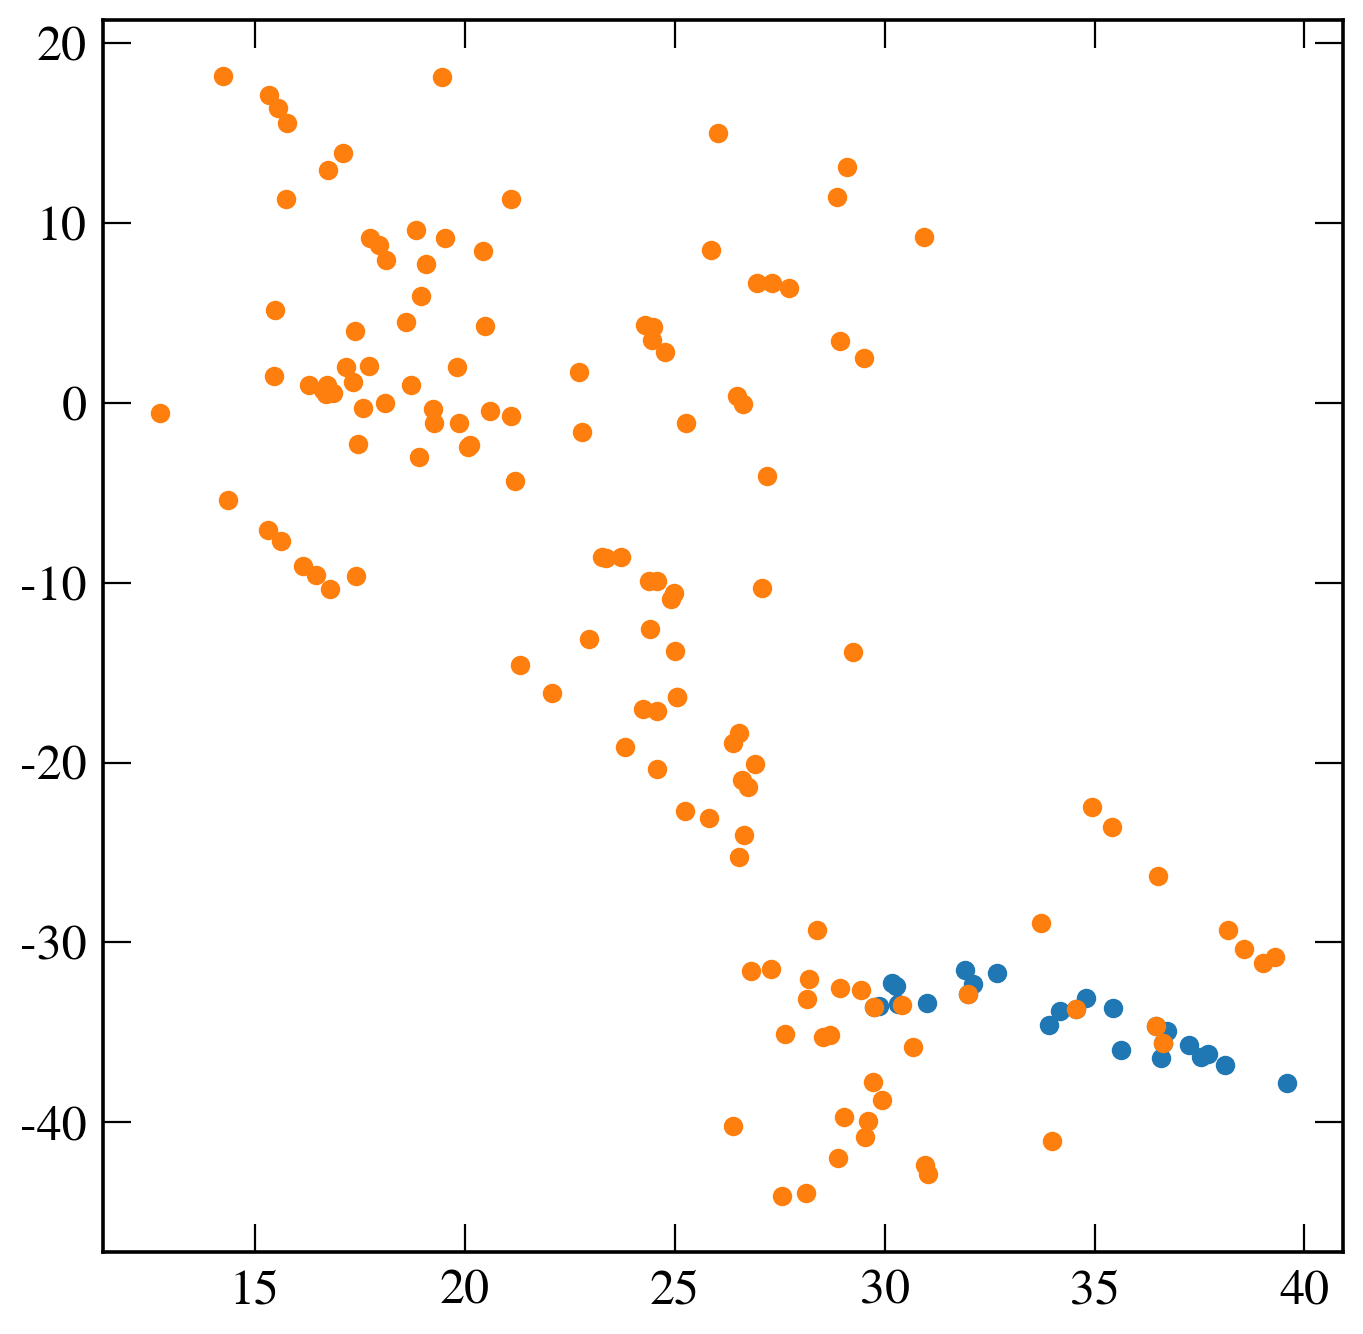

In [983]:
plt.plot(tin1['ra'], tin1['dec'], 'o')
plt.plot(tin2['ra'], tin2['dec'], 'o')

In [984]:
ind_cp = tout['name']=='Cetus-Palca'
ind_kw = tout['name']=='Kwando'

In [985]:
tout[ind_cp | ind_kw]

name,ra,dec,distance,pmra,pmdec,Vr,rperi,rapo,T,ecc,Etot,L,Lx,Ly,Lz,Lperp,Lmax,circLz
,deg,deg,kpc,mas / yr,mas / yr,km / s,kpc,kpc,Myr,,kpc2 / Myr2,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,kpc2 / Myr,
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Cetus-Palca,34.95272751616766,-35.03911008429195,6.325414552896545,0.8669451227099946,-0.23856029036923987,99.1304743118773,10.391698158629774,12.123232682150622,232.0,0.07690605561997058,-0.11879484341366217,2.4391987618245614,1.3489089968556518,-0.5893130591542122,-1.9449537876768836,1.4720208434284539,2.57256187758416,0.7560377088007499
Kwando,26.488922820381447,-3.874784939975089,27.892798020107364,0.7754555751695744,-0.5423432627779622,-85.80351256835402,14.571857469285032,33.43285618837206,529.9409722222222,0.3928988901713522,-0.08453436748800335,4.3939690420389725,3.392075840080098,1.5080877458299422,-2.350841719133669,3.712210548174435,5.204047758033216,0.451733309999855
